In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 42.2 MB/s eta 0:00:00
ERROR: Operation cancelled by user


In [2]:
import torch as t
import torch
import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import time
import numpy as np
import sklearn
import pickle
import re
from torch.optim import Adam

In [3]:
def create_dataset(i_start=0, i_end=50, operation=t.add):
    # Create a tensor of all possible pairs of numbers from i_start to i_end
    X1 = t.arange(i_start, i_end)
    X2 = t.arange(i_start, i_end)
    X1, X2 = t.meshgrid(X1, X2)
    X = t.stack([X1.reshape(-1), X2.reshape(-1)], dim=1)

    # Calculate the correct answers using the specified operation
    y = operation(X[:, 0], X[:, 1])

    return X, y

In [4]:
X,y = create_dataset(0,50)

/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
def encode_problems(X, strategy='baseline'):
  output_strings = [] 
  len = X.shape[0]
  i = 0 
  for xi in X: 
    if strategy == 'baseline':
      encode_string = str(xi[0].item())+ "+" + str(xi[1].item()) + "="
      output_strings.append(encode_string)   
      i+=1
  print(output_strings) 
  return output_strings

In [6]:
def load_LLM(default="EleutherAI/gpt-neo-1.3B", device='cpu'): 
  tokenizer = GPT2Tokenizer.from_pretrained(default)
  model = GPT2LMHeadModel.from_pretrained(default).to(device)
  return model, tokenizer

In [7]:
model, tokenizer = load_LLM("gpt2")

In [8]:
class NumericDataset(Dataset):
  def __init__(self, problems, answers, tokenizer):
    self.X = []
    for i in problems:
      self.X.append(i) 
    
    print(answers)

    # for idx,i in enumerate(self.X):
    #   l = self.X[idx].split('=')
    #   self.X[idx]= "<startofstaring>" + l[0]+ "=" + " <answer>: " + l[1] + "<endofstring>"
    j=0
    for idx, i in enumerate(self.X):
      self.X[idx] = "<startofstaring>" + i + " <answer>: " + str(answers[j].item()) + "<endofstring>" 

      j+=1
    # self.X = self.X[:1000]
    print(self.X)

    tokenizer.pad_token = tokenizer.eos_token   
    self.X_encoded = tokenizer(self.X, padding = True , truncation = True, return_tensors="pt")
    self.input_ids = self.X_encoded['input_ids']
    self.attention_mask = self.X_encoded['attention_mask']


  def __len__(self):
    return len(self.X)
  
  def __getitem__(self,idx):
    return (self.input_ids[idx], self.attention_mask[idx])

In [9]:
tokenizer.add_special_tokens({"pad_token":"<pad>", "bos_token":"<startofstring>", "eos_token":"<endofstring>"})

3

In [10]:
tokenizer.add_tokens(["<answer>:"])

1

In [11]:
input_strings = encode_problems(X, 'baseline')

['0+0=', '0+1=', '0+2=', '0+3=', '0+4=', '0+5=', '0+6=', '0+7=', '0+8=', '0+9=', '0+10=', '0+11=', '0+12=', '0+13=', '0+14=', '0+15=', '0+16=', '0+17=', '0+18=', '0+19=', '0+20=', '0+21=', '0+22=', '0+23=', '0+24=', '0+25=', '0+26=', '0+27=', '0+28=', '0+29=', '0+30=', '0+31=', '0+32=', '0+33=', '0+34=', '0+35=', '0+36=', '0+37=', '0+38=', '0+39=', '0+40=', '0+41=', '0+42=', '0+43=', '0+44=', '0+45=', '0+46=', '0+47=', '0+48=', '0+49=', '1+0=', '1+1=', '1+2=', '1+3=', '1+4=', '1+5=', '1+6=', '1+7=', '1+8=', '1+9=', '1+10=', '1+11=', '1+12=', '1+13=', '1+14=', '1+15=', '1+16=', '1+17=', '1+18=', '1+19=', '1+20=', '1+21=', '1+22=', '1+23=', '1+24=', '1+25=', '1+26=', '1+27=', '1+28=', '1+29=', '1+30=', '1+31=', '1+32=', '1+33=', '1+34=', '1+35=', '1+36=', '1+37=', '1+38=', '1+39=', '1+40=', '1+41=', '1+42=', '1+43=', '1+44=', '1+45=', '1+46=', '1+47=', '1+48=', '1+49=', '2+0=', '2+1=', '2+2=', '2+3=', '2+4=', '2+5=', '2+6=', '2+7=', '2+8=', '2+9=', '2+10=', '2+11=', '2+12=', '2+13=', '2+

In [12]:
numericDataset = NumericDataset(input_strings, y, tokenizer)

tensor([ 0,  1,  2,  ..., 96, 97, 98])
['<startofstaring>0+0= <answer>: 0<endofstring>', '<startofstaring>0+1= <answer>: 1<endofstring>', '<startofstaring>0+2= <answer>: 2<endofstring>', '<startofstaring>0+3= <answer>: 3<endofstring>', '<startofstaring>0+4= <answer>: 4<endofstring>', '<startofstaring>0+5= <answer>: 5<endofstring>', '<startofstaring>0+6= <answer>: 6<endofstring>', '<startofstaring>0+7= <answer>: 7<endofstring>', '<startofstaring>0+8= <answer>: 8<endofstring>', '<startofstaring>0+9= <answer>: 9<endofstring>', '<startofstaring>0+10= <answer>: 10<endofstring>', '<startofstaring>0+11= <answer>: 11<endofstring>', '<startofstaring>0+12= <answer>: 12<endofstring>', '<startofstaring>0+13= <answer>: 13<endofstring>', '<startofstaring>0+14= <answer>: 14<endofstring>', '<startofstaring>0+15= <answer>: 15<endofstring>', '<startofstaring>0+16= <answer>: 16<endofstring>', '<startofstaring>0+17= <answer>: 17<endofstring>', '<startofstaring>0+18= <answer>: 18<endofstring>', '<startofst

In [13]:
bs = 10
train_loader = torch.utils.data.DataLoader(numericDataset, batch_size = bs, shuffle = bs)

In [14]:
model.resize_token_embeddings(len(tokenizer))

Embedding(50261, 768)

In [15]:
model.train()
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50261, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50261, bias=False)
)

In [ ]:
# def train(numericDataset, model, optim):
#   epochs = 3
#   for i in tqdm.tqdm(range(epochs)):
#     for X, a in numericDataset:
#       optim.zero_grad()
#       loss = model(X, attention_mask=a,labels=X).loss
#       loss.backward()
#       optim.step()
#     torch.save(model.state_dict(), "model_state.pt")

In [ ]:
# optim = Adam(model.parameters(), lr=1e-3)

In [16]:
from sklearn.model_selection import train_test_split
import torch

In [17]:
type(input_strings)

list

In [18]:
type(y)

torch.Tensor

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(input_strings, y, test_size=0.2, random_state=42)


In [20]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50261, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50261, bias=False)
)

In [22]:
from os import XATTR_SIZE_MAX
def train_and_evaluate(train_dataset, val_dataset, model, optimizer, scheduler, epochs):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1} of {epochs}")
        model.train()
        train_loss = 0
        
    #     for i in tqdm.tqdm(range(epochs)):
    # for X, a in numericDataset:

        for batch in tqdm.tqdm(range(epochs)):
          for X, a in DataLoader(train_dataset, batch_size=10):
            optimizer.zero_grad()
            # input_ids = batch['input_ids'].to(device)
            # attention_mask = batch['attention_mask'].to(device)
            # labels = batch['labels'].to(device)
            X = X.to(device)
            a = a.to(device)
            outputs = model(X, attention_mask=a,labels=X)
            loss = outputs[0]
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            scheduler.step()

        avg_train_loss = train_loss / len(train_dataset)
        print(f"Avg training loss: {avg_train_loss}")

        model.eval()
        val_loss = 0

        for batch in tqdm.tqdm(range(epochs)):
          for X, a in DataLoader(train_dataset, batch_size=10):
            with torch.no_grad():
              X = X.to(device)
              a = a.to(device)
              outputs = model(X, attention_mask=a, labels=X)
              loss = outputs[0]
              val_loss += loss.item()

        avg_val_loss = val_loss / len(val_dataset)
        print(f"Avg validation loss: {avg_val_loss}")

    return model

In [23]:
train_dataset = NumericDataset(X_train, Y_train, tokenizer)

tensor([53, 46, 56,  ..., 27, 61, 42])
['<startofstaring>31+22= <answer>: 53<endofstring>', '<startofstaring>23+23= <answer>: 46<endofstring>', '<startofstaring>45+11= <answer>: 56<endofstring>', '<startofstaring>37+46= <answer>: 83<endofstring>', '<startofstaring>8+11= <answer>: 19<endofstring>', '<startofstaring>18+19= <answer>: 37<endofstring>', '<startofstaring>25+44= <answer>: 69<endofstring>', '<startofstaring>26+9= <answer>: 35<endofstring>', '<startofstaring>42+38= <answer>: 80<endofstring>', '<startofstaring>1+18= <answer>: 19<endofstring>', '<startofstaring>4+44= <answer>: 48<endofstring>', '<startofstaring>4+36= <answer>: 40<endofstring>', '<startofstaring>37+34= <answer>: 71<endofstring>', '<startofstaring>29+18= <answer>: 47<endofstring>', '<startofstaring>25+13= <answer>: 38<endofstring>', '<startofstaring>14+35= <answer>: 49<endofstring>', '<startofstaring>46+33= <answer>: 79<endofstring>', '<startofstaring>30+5= <answer>: 35<endofstring>', '<startofstaring>6+6= <answer>

In [24]:
val_dataset = NumericDataset(X_val, Y_val, tokenizer)

tensor([75, 32, 12, 62, 58, 72, 19, 34, 59, 82, 27, 93, 74, 33, 80, 53, 43, 31,
        18, 23, 36, 38, 24,  5, 51, 71,  7, 47, 47, 58, 50, 29, 39, 28, 62, 65,
        35, 45, 57, 94, 41, 56, 85, 26, 78, 33, 30, 27, 60, 74, 96, 84, 69, 63,
        69, 28, 46, 49, 69, 20, 38, 47, 26, 52, 68, 32, 26, 70, 38, 28, 14, 77,
        78, 19, 84, 29, 28, 80, 83, 51, 47, 84, 86, 19, 77, 35, 47, 43, 41, 54,
        26, 46, 53, 28, 63,  1, 30, 12, 28, 89, 70, 67, 37, 46, 15, 54, 88, 43,
        35, 58, 53, 74, 24, 17, 84, 29, 24, 73, 20, 67, 76, 68, 45, 60, 29, 65,
        60, 23, 76, 50, 64, 56, 52, 56, 48, 59, 18, 79,  7, 71, 68, 64, 48, 91,
        57, 54, 43, 75, 18, 32, 49, 14, 31, 36, 27, 44, 68, 70, 20, 43, 69, 36,
        55, 28, 12, 66, 21, 40, 52, 73, 34, 44, 40, 79, 55, 68, 17, 31, 42, 46,
        38, 54,  6, 73, 88, 59, 61, 26, 42, 82, 70, 59, 11, 21, 25, 72, 58, 80,
        36, 51, 56, 39, 71, 30, 36, 23, 71, 80, 31, 48,  5, 46, 31, 51, 48, 48,
        27, 47, 38, 52, 67, 78, 75, 62, 

In [25]:
from transformers import AdamW, get_linear_schedule_with_warmup


In [26]:
optimizer = AdamW(model.parameters(), lr=5e-5)
total_steps = len(train_dataset) * 3

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [27]:
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


In [28]:
epochs = 5

In [29]:
trained_model = train_and_evaluate(train_dataset, val_dataset, model, optimizer, scheduler, epochs)

Epoch 1 of 5


100%|██████████| 5/5 [01:18<00:00, 15.71s/it]


Avg training loss: 0.6834852678701282


100%|██████████| 5/5 [00:16<00:00,  3.28s/it]


Avg validation loss: 1.7674348503351212
Epoch 2 of 5


100%|██████████| 5/5 [01:13<00:00, 14.67s/it]


Avg training loss: 0.44927730910480024


100%|██████████| 5/5 [00:15<00:00,  3.17s/it]


Avg validation loss: 1.5703318439424039
Epoch 3 of 5


100%|██████████| 5/5 [01:11<00:00, 14.37s/it]


Avg training loss: 0.4042024763301015


100%|██████████| 5/5 [00:16<00:00,  3.25s/it]


Avg validation loss: 1.4387809790670871
Epoch 4 of 5


100%|██████████| 5/5 [01:11<00:00, 14.35s/it]


Avg training loss: 0.37356250774115324


100%|██████████| 5/5 [00:15<00:00,  3.18s/it]


Avg validation loss: 1.3571206398308278
Epoch 5 of 5


100%|██████████| 5/5 [01:11<00:00, 14.32s/it]


Avg training loss: 0.35406082320958376


100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

Avg validation loss: 1.3202784761786461


In [30]:
def infer(input):
  input = "<startofstring>" + input + " <answer>: "
  input = tokenizer(input, return_tensors = "pt")
  X = input["input_ids"].to(device)
  a = input["attention_mask"].to(device)
  output = model.generate(X, attention_mask = a, do_sample = False, max_length = 50, temperature = 0.001)
  # output = trained_model.generate(X, attention_mask = a, do_sample = False, max_length = 50, temperature = 0.001)
  output_float = output[0].float()
  probs = torch.softmax(output_float, dim=-1).tolist()
  output_str = tokenizer.decode(output[0]) 

  # token_probs = {}
  # for i, token_id in enumerate(output[0]):
  #   token = tokenizer.decode([token_id])
  #   prob = probs[i][token_id.item()].item()
  #   token_probs[token] = prob

  return output_str, probs, output[0]



*   How do I know if the model is learing or remembering? 
*   It seems to be giving sort of accurate results for the arthematic operations within the range. 



In [31]:
s, probs, output = infer("22+25 = ") 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [32]:
s

'<startofstring> 22+25 = <answer>: 52 <endofstring> 63 <endofstring> 74 <endofstring> 77 <endofstring> <answer>: <answer>: 85 <endofstring> <answer>: <answer>: 92 <endofstring> 94 <endofstring> <startofstring> <startofstring> <startofstring> <endofstring> <endofstring> <endofstring> <endofstring> <endofstring> <endofstring> <endofstring> <endofstring> <endofstring> <endofstring> <endofstring> <endofstring> <endofstring> <endofstring> <endofstring> <endofstring> <endofstring> <endofstring> <endofstring> <endofstring> <endofstring> <endofstring> <endofstring>'

In [ ]:
y = int(''.join(filter(str.isdigit, s)))

In [ ]:
s= int((" ".join(filter(str.isdigit, s)))[0])

In [51]:
import numpy as np
count = 0
predicted_values = []
y_binary = []
pred_correct_values = []
for i in range(len(X_test)):
  s, probs, output = infer(X_test[i])
  print(i)
  true_val= Y_test[i].item()
  if s.split("<answer>: ")[1].split("<endofstring>")[0] == '':
    val = np.nan
    y_binary.append(0)
  else:
    val = s.split("<answer>: ")[1].split("<endofstring>")[0]
    if int(val) == true_val:
       pred_correct_values.append(val)
       count+=1
       y_binary.append(1)
    else:
      y_binary.append(0)
  predicted_values.append(val)
  # true_val= Y_test[i].item()
  print("Equation:", X_test[i])
  print("True Values:", true_val)
  print("Predicted Values:", val)

 


  # if pred_val>= true_val-3 and pred_val<= true_val+3:
  #   count+=1

print("Accuracy: ", (count*100)/len(X_test))
  
  

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0
Equation: 28+47=
True Values: 75
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1
Equation: 22+14=
True Values: 36
Predicted Values: 36 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2
Equation: 21+14=
True Values: 35
Predicted Values: 35 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


3
Equation: 45+37=
True Values: 82
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


4
Equation: 30+37=
True Values: 67
Predicted Values: 77 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


5
Equation: 13+18=
True Values: 31
Predicted Values: 31 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


6
Equation: 31+33=
True Values: 64
Predicted Values: 64 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


7
Equation: 48+4=
True Values: 52
Predicted Values: 52 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


8
Equation: 9+47=
True Values: 56
Predicted Values: 56 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


9
Equation: 49+30=
True Values: 79
Predicted Values: 79 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


10
Equation: 9+21=
True Values: 30
Predicted Values: 30 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


11
Equation: 4+46=
True Values: 50
Predicted Values: 50 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


12
Equation: 18+23=
True Values: 41
Predicted Values: 41 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


13
Equation: 22+31=
True Values: 53
Predicted Values: 53 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


14
Equation: 13+20=
True Values: 33
Predicted Values: 33 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


15
Equation: 18+16=
True Values: 34
Predicted Values: 30 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


16
Equation: 28+14=
True Values: 42
Predicted Values: 42 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


17
Equation: 32+6=
True Values: 38
Predicted Values: 38 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


18
Equation: 8+2=
True Values: 10
Predicted Values: 10 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


19
Equation: 22+3=
True Values: 25
Predicted Values: 25 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


20
Equation: 41+22=
True Values: 63
Predicted Values: 63 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


21
Equation: 14+19=
True Values: 33
Predicted Values: 33 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


22
Equation: 40+11=
True Values: 51
Predicted Values: 51 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


23
Equation: 48+36=
True Values: 84
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


24
Equation: 3+46=
True Values: 49
Predicted Values: 49 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


25
Equation: 17+41=
True Values: 58
Predicted Values: 58 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


26
Equation: 25+14=
True Values: 39
Predicted Values: 39 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


27
Equation: 20+34=
True Values: 54
Predicted Values: 54 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


28
Equation: 26+25=
True Values: 51
Predicted Values: 51 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


29
Equation: 10+9=
True Values: 19
Predicted Values: 17 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


30
Equation: 28+27=
True Values: 55
Predicted Values: 55 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


31
Equation: 3+44=
True Values: 47
Predicted Values: 47 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


32
Equation: 23+29=
True Values: 52
Predicted Values: 52 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


33
Equation: 40+32=
True Values: 72
Predicted Values: 72 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


34
Equation: 18+32=
True Values: 50
Predicted Values: 50 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


35
Equation: 22+24=
True Values: 46
Predicted Values: 46 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


36
Equation: 36+22=
True Values: 58
Predicted Values: 58 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


37
Equation: 27+16=
True Values: 43
Predicted Values: 43 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


38
Equation: 39+42=
True Values: 81
Predicted Values: 81 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


39
Equation: 25+8=
True Values: 33
Predicted Values: 33 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


40
Equation: 45+24=
True Values: 69
Predicted Values: 63 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


41
Equation: 25+23=
True Values: 48
Predicted Values: 52 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


42
Equation: 38+36=
True Values: 74
Predicted Values: 74 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


43
Equation: 25+16=
True Values: 41
Predicted Values: 41 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


44
Equation: 15+22=
True Values: 37
Predicted Values: 37 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


45
Equation: 32+8=
True Values: 40
Predicted Values: 44 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


46
Equation: 26+11=
True Values: 37
Predicted Values: 37 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


47
Equation: 2+34=
True Values: 36
Predicted Values: 36 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


48
Equation: 37+5=
True Values: 42
Predicted Values: 42 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


49
Equation: 47+49=
True Values: 96
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


50
Equation: 8+20=
True Values: 28
Predicted Values: 28 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


51
Equation: 35+5=
True Values: 40
Predicted Values: 40 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


52
Equation: 14+7=
True Values: 21
Predicted Values: 21 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


53
Equation: 1+43=
True Values: 44
Predicted Values: 44 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


54
Equation: 1+6=
True Values: 7
Predicted Values: 7 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


55
Equation: 4+18=
True Values: 22
Predicted Values: 22 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


56
Equation: 20+36=
True Values: 56
Predicted Values: 56 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


57
Equation: 25+43=
True Values: 68
Predicted Values: 68 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


58
Equation: 39+2=
True Values: 41
Predicted Values: 41 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


59
Equation: 28+49=
True Values: 77
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


60
Equation: 47+9=
True Values: 56
Predicted Values: 56 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


61
Equation: 29+15=
True Values: 44
Predicted Values: 44 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


62
Equation: 5+48=
True Values: 53
Predicted Values: 53 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


63
Equation: 43+27=
True Values: 70
Predicted Values: 70 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


64
Equation: 3+28=
True Values: 31
Predicted Values: 31 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


65
Equation: 23+37=
True Values: 60
Predicted Values: 64 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


66
Equation: 29+22=
True Values: 51
Predicted Values: 51 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


67
Equation: 3+38=
True Values: 41
Predicted Values: 41 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


68
Equation: 11+22=
True Values: 33
Predicted Values: 33 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


69
Equation: 8+33=
True Values: 41
Predicted Values: 41 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


70
Equation: 10+18=
True Values: 28
Predicted Values: 28 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


71
Equation: 46+46=
True Values: 92
Predicted Values: 90 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


72
Equation: 45+21=
True Values: 66
Predicted Values: 66 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


73
Equation: 21+34=
True Values: 55
Predicted Values: 65 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


74
Equation: 25+38=
True Values: 63
Predicted Values: 63 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


75
Equation: 22+23=
True Values: 45
Predicted Values: 45 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


76
Equation: 26+41=
True Values: 67
Predicted Values: 67 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


77
Equation: 45+6=
True Values: 51
Predicted Values: 51 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


78
Equation: 29+40=
True Values: 69
Predicted Values: 79 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


79
Equation: 0+43=
True Values: 43
Predicted Values: 43 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


80
Equation: 37+28=
True Values: 65
Predicted Values: 65 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


81
Equation: 9+0=
True Values: 9
Predicted Values: 9 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


82
Equation: 40+45=
True Values: 85
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


83
Equation: 0+44=
True Values: 44
Predicted Values: 44 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


84
Equation: 25+33=
True Values: 58
Predicted Values: 58 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


85
Equation: 39+17=
True Values: 56
Predicted Values: 56 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


86
Equation: 41+40=
True Values: 81
Predicted Values: 81 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


87
Equation: 5+4=
True Values: 9
Predicted Values: 9 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


88
Equation: 38+45=
True Values: 83
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


89
Equation: 37+24=
True Values: 61
Predicted Values: 61 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


90
Equation: 37+12=
True Values: 49
Predicted Values: 49 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


91
Equation: 11+14=
True Values: 25
Predicted Values: 25 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


92
Equation: 4+12=
True Values: 16
Predicted Values: 18 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


93
Equation: 17+16=
True Values: 33
Predicted Values: 29 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


94
Equation: 14+42=
True Values: 56
Predicted Values: 56 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


95
Equation: 25+1=
True Values: 26
Predicted Values: 26 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


96
Equation: 20+47=
True Values: 67
Predicted Values: 77 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


97
Equation: 34+36=
True Values: 70
Predicted Values: 70 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


98
Equation: 20+17=
True Values: 37
Predicted Values: 37 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


99
Equation: 3+20=
True Values: 23
Predicted Values: 23 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


100
Equation: 41+46=
True Values: 87
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


101
Equation: 49+37=
True Values: 86
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


102
Equation: 44+17=
True Values: 61
Predicted Values: 61 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


103
Equation: 35+47=
True Values: 82
Predicted Values: 92 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


104
Equation: 10+44=
True Values: 54
Predicted Values: 54 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


105
Equation: 24+21=
True Values: 45
Predicted Values: 45 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


106
Equation: 9+13=
True Values: 22
Predicted Values: 26 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


107
Equation: 19+38=
True Values: 57
Predicted Values: 61 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


108
Equation: 26+21=
True Values: 47
Predicted Values: 47 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


109
Equation: 12+2=
True Values: 14
Predicted Values: 14 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


110
Equation: 26+36=
True Values: 62
Predicted Values: 62 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


111
Equation: 46+39=
True Values: 85
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


112
Equation: 25+10=
True Values: 35
Predicted Values: 35 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


113
Equation: 42+14=
True Values: 56
Predicted Values: 56 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


114
Equation: 16+7=
True Values: 23
Predicted Values: 23 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


115
Equation: 17+36=
True Values: 53
Predicted Values: 59 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


116
Equation: 31+32=
True Values: 63
Predicted Values: 63 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


117
Equation: 32+14=
True Values: 46
Predicted Values: 46 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


118
Equation: 36+37=
True Values: 73
Predicted Values: 73 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


119
Equation: 37+23=
True Values: 60
Predicted Values: 60 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


120
Equation: 5+32=
True Values: 37
Predicted Values: 37 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


121
Equation: 4+10=
True Values: 14
Predicted Values: 16 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


122
Equation: 2+11=
True Values: 13
Predicted Values: 13 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


123
Equation: 38+20=
True Values: 58
Predicted Values: 58 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


124
Equation: 43+15=
True Values: 58
Predicted Values: 58 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


125
Equation: 9+7=
True Values: 16
Predicted Values: 16 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


126
Equation: 16+19=
True Values: 35
Predicted Values: 35 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


127
Equation: 43+34=
True Values: 77
Predicted Values: 77 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


128
Equation: 33+5=
True Values: 38
Predicted Values: 38 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


129
Equation: 5+2=
True Values: 7
Predicted Values: 7 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


130
Equation: 5+1=
True Values: 6
Predicted Values: 6 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


131
Equation: 30+39=
True Values: 69
Predicted Values: 79 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


132
Equation: 42+29=
True Values: 71
Predicted Values: 71 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


133
Equation: 38+26=
True Values: 64
Predicted Values: 64 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


134
Equation: 20+18=
True Values: 38
Predicted Values: 38 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


135
Equation: 8+22=
True Values: 30
Predicted Values: 30 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


136
Equation: 23+25=
True Values: 48
Predicted Values: 52 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


137
Equation: 12+20=
True Values: 32
Predicted Values: 32 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


138
Equation: 3+23=
True Values: 26
Predicted Values: 26 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


139
Equation: 9+36=
True Values: 45
Predicted Values: 45 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


140
Equation: 39+35=
True Values: 74
Predicted Values: 74 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


141
Equation: 21+30=
True Values: 51
Predicted Values: 51 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


142
Equation: 22+17=
True Values: 39
Predicted Values: 35 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


143
Equation: 27+7=
True Values: 34
Predicted Values: 30 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


144
Equation: 20+41=
True Values: 61
Predicted Values: 61 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


145
Equation: 21+40=
True Values: 61
Predicted Values: 61 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


146
Equation: 27+5=
True Values: 32
Predicted Values: 32 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


147
Equation: 4+11=
True Values: 15
Predicted Values: 15 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


148
Equation: 12+13=
True Values: 25
Predicted Values: 19 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


149
Equation: 42+49=
True Values: 91
Predicted Values: 91 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


150
Equation: 9+14=
True Values: 23
Predicted Values: 23 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


151
Equation: 29+17=
True Values: 46
Predicted Values: 36 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


152
Equation: 11+4=
True Values: 15
Predicted Values: 13 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


153
Equation: 18+7=
True Values: 25
Predicted Values: 23 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


154
Equation: 19+43=
True Values: 62
Predicted Values: 72 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


155
Equation: 39+18=
True Values: 57
Predicted Values: 57 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


156
Equation: 35+38=
True Values: 73
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


157
Equation: 31+48=
True Values: 79
Predicted Values: 79 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


158
Equation: 1+46=
True Values: 47
Predicted Values: 47 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


159
Equation: 39+14=
True Values: 53
Predicted Values: 53 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


160
Equation: 27+14=
True Values: 41
Predicted Values: 37 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


161
Equation: 38+24=
True Values: 62
Predicted Values: 62 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


162
Equation: 12+11=
True Values: 23
Predicted Values: 23 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


163
Equation: 8+45=
True Values: 53
Predicted Values: 53 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


164
Equation: 4+37=
True Values: 41
Predicted Values: 43 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


165
Equation: 46+10=
True Values: 56
Predicted Values: 56 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


166
Equation: 17+23=
True Values: 40
Predicted Values: 46 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


167
Equation: 49+47=
True Values: 96
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


168
Equation: 41+4=
True Values: 45
Predicted Values: 45 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


169
Equation: 33+23=
True Values: 56
Predicted Values: 56 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


170
Equation: 42+22=
True Values: 64
Predicted Values: 64 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


171
Equation: 16+39=
True Values: 55
Predicted Values: 65 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


172
Equation: 11+31=
True Values: 42
Predicted Values: 42 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


173
Equation: 25+31=
True Values: 56
Predicted Values: 56 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


174
Equation: 19+29=
True Values: 48
Predicted Values: 58 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


175
Equation: 15+40=
True Values: 55
Predicted Values: 55 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


176
Equation: 16+41=
True Values: 57
Predicted Values: 57 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


177
Equation: 9+32=
True Values: 41
Predicted Values: 51 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


178
Equation: 38+10=
True Values: 48
Predicted Values: 48 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


179
Equation: 12+21=
True Values: 33
Predicted Values: 33 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


180
Equation: 30+2=
True Values: 32
Predicted Values: 32 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


181
Equation: 6+32=
True Values: 38
Predicted Values: 44 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


182
Equation: 9+28=
True Values: 37
Predicted Values: 37 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


183
Equation: 29+44=
True Values: 73
Predicted Values: 77 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


184
Equation: 10+7=
True Values: 17
Predicted Values: 17 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


185
Equation: 29+0=
True Values: 29
Predicted Values: 29 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


186
Equation: 48+23=
True Values: 71
Predicted Values: 71 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


187
Equation: 12+43=
True Values: 55
Predicted Values: 55 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


188
Equation: 9+30=
True Values: 39
Predicted Values: 49 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


189
Equation: 29+5=
True Values: 34
Predicted Values: 34 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


190
Equation: 47+44=
True Values: 91
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


191
Equation: 20+11=
True Values: 31
Predicted Values: 31 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


192
Equation: 15+14=
True Values: 29
Predicted Values: 23 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


193
Equation: 25+39=
True Values: 64
Predicted Values: 74 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


194
Equation: 24+23=
True Values: 47
Predicted Values: 51 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


195
Equation: 26+33=
True Values: 59
Predicted Values: 59 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


196
Equation: 12+17=
True Values: 29
Predicted Values: 29 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


197
Equation: 10+21=
True Values: 31
Predicted Values: 31 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


198
Equation: 11+32=
True Values: 43
Predicted Values: 43 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


199
Equation: 21+8=
True Values: 29
Predicted Values: 29 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


200
Equation: 28+6=
True Values: 34
Predicted Values: 34 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


201
Equation: 5+46=
True Values: 51
Predicted Values: 57 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


202
Equation: 48+42=
True Values: 90
Predicted Values: 90 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


203
Equation: 21+11=
True Values: 32
Predicted Values: 32 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


204
Equation: 17+7=
True Values: 24
Predicted Values: 22 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


205
Equation: 33+42=
True Values: 75
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


206
Equation: 8+7=
True Values: 15
Predicted Values: 11 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


207
Equation: 21+28=
True Values: 49
Predicted Values: 49 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


208
Equation: 21+33=
True Values: 54
Predicted Values: 54 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


209
Equation: 3+18=
True Values: 21
Predicted Values: 21 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


210
Equation: 43+30=
True Values: 73
Predicted Values: 73 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


211
Equation: 4+39=
True Values: 43
Predicted Values: 43 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


212
Equation: 46+5=
True Values: 51
Predicted Values: 51 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


213
Equation: 39+47=
True Values: 86
Predicted Values: 94 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


214
Equation: 38+1=
True Values: 39
Predicted Values: 39 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


215
Equation: 21+0=
True Values: 21
Predicted Values: 21 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


216
Equation: 38+12=
True Values: 50
Predicted Values: 50 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


217
Equation: 37+17=
True Values: 54
Predicted Values: 54 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


218
Equation: 41+45=
True Values: 86
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


219
Equation: 10+22=
True Values: 32
Predicted Values: 32 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


220
Equation: 34+37=
True Values: 71
Predicted Values: 71 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


221
Equation: 49+22=
True Values: 71
Predicted Values: 71 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


222
Equation: 36+47=
True Values: 83
Predicted Values: 93 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


223
Equation: 47+18=
True Values: 65
Predicted Values: 63 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


224
Equation: 44+49=
True Values: 93
Predicted Values: 92 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


225
Equation: 37+33=
True Values: 70
Predicted Values: 74 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


226
Equation: 30+11=
True Values: 41
Predicted Values: 41 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


227
Equation: 29+9=
True Values: 38
Predicted Values: 28 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


228
Equation: 38+38=
True Values: 76
Predicted Values: 76 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


229
Equation: 34+23=
True Values: 57
Predicted Values: 57 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


230
Equation: 40+25=
True Values: 65
Predicted Values: 65 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


231
Equation: 32+7=
True Values: 39
Predicted Values: 39 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


232
Equation: 39+27=
True Values: 66
Predicted Values: 66 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


233
Equation: 10+8=
True Values: 18
Predicted Values: 22 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


234
Equation: 12+32=
True Values: 44
Predicted Values: 44 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


235
Equation: 18+15=
True Values: 33
Predicted Values: 29 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


236
Equation: 5+9=
True Values: 14
Predicted Values: 16 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


237
Equation: 27+45=
True Values: 72
Predicted Values: 72 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


238
Equation: 45+45=
True Values: 90
Predicted Values: 90 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


239
Equation: 46+21=
True Values: 67
Predicted Values: 67 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


240
Equation: 16+2=
True Values: 18
Predicted Values: 18 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


241
Equation: 38+35=
True Values: 73
Predicted Values: 73 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


242
Equation: 23+46=
True Values: 69
Predicted Values: 73 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


243
Equation: 38+44=
True Values: 82
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


244
Equation: 15+6=
True Values: 21
Predicted Values: 17 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


245
Equation: 16+1=
True Values: 17
Predicted Values: 17 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


246
Equation: 4+33=
True Values: 37
Predicted Values: 37 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


247
Equation: 30+14=
True Values: 44
Predicted Values: 44 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


248
Equation: 18+40=
True Values: 58
Predicted Values: 68 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


249
Equation: 19+48=
True Values: 67
Predicted Values: 77 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


250
Equation: 22+2=
True Values: 24
Predicted Values: 24 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


251
Equation: 29+13=
True Values: 42
Predicted Values: 42 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


252
Equation: 37+26=
True Values: 63
Predicted Values: 53 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


253
Equation: 24+25=
True Values: 49
Predicted Values: 49 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


254
Equation: 6+24=
True Values: 30
Predicted Values: 30 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


255
Equation: 35+13=
True Values: 48
Predicted Values: 48 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


256
Equation: 39+3=
True Values: 42
Predicted Values: 42 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


257
Equation: 27+27=
True Values: 54
Predicted Values: 54 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


258
Equation: 2+0=
True Values: 2
Predicted Values: 2 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


259
Equation: 49+31=
True Values: 80
Predicted Values: 70 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


260
Equation: 26+40=
True Values: 66
Predicted Values: 66 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


261
Equation: 7+37=
True Values: 44
Predicted Values: 44 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


262
Equation: 39+4=
True Values: 43
Predicted Values: 43 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


263
Equation: 3+29=
True Values: 32
Predicted Values: 32 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


264
Equation: 33+44=
True Values: 77
Predicted Values: 77 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


265
Equation: 33+12=
True Values: 45
Predicted Values: 45 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


266
Equation: 26+4=
True Values: 30
Predicted Values: 28 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


267
Equation: 18+27=
True Values: 45
Predicted Values: 55 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


268
Equation: 28+30=
True Values: 58
Predicted Values: 58 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


269
Equation: 45+18=
True Values: 63
Predicted Values: 63 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


270
Equation: 2+41=
True Values: 43
Predicted Values: 43 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


271
Equation: 7+18=
True Values: 25
Predicted Values: 23 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


272
Equation: 48+45=
True Values: 93
Predicted Values: 93 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


273
Equation: 21+35=
True Values: 56
Predicted Values: 56 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


274
Equation: 7+17=
True Values: 24
Predicted Values: 30 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


275
Equation: 33+24=
True Values: 57
Predicted Values: nan


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


276
Equation: 20+44=
True Values: 64
Predicted Values: 64 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


277
Equation: 6+18=
True Values: 24
Predicted Values: 24 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


278
Equation: 30+38=
True Values: 68
Predicted Values: 68 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


279
Equation: 4+47=
True Values: 51
Predicted Values: 61 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


280
Equation: 6+21=
True Values: 27
Predicted Values: 27 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


281
Equation: 36+33=
True Values: 69
Predicted Values: 69 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


282
Equation: 36+39=
True Values: 75
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


283
Equation: 19+49=
True Values: 68
Predicted Values: 78 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


284
Equation: 18+42=
True Values: 60
Predicted Values: 70 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


285
Equation: 35+22=
True Values: 57
Predicted Values: 57 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


286
Equation: 0+29=
True Values: 29
Predicted Values: 29 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


287
Equation: 25+49=
True Values: 74
Predicted Values: 74 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


288
Equation: 39+43=
True Values: 82
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


289
Equation: 38+14=
True Values: 52
Predicted Values: 52 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


290
Equation: 13+45=
True Values: 58
Predicted Values: 58 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


291
Equation: 49+20=
True Values: 69
Predicted Values: 59 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


292
Equation: 40+28=
True Values: 68
Predicted Values: 68 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


293
Equation: 32+0=
True Values: 32
Predicted Values: 32 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


294
Equation: 46+29=
True Values: 75
Predicted Values: 65 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


295
Equation: 24+31=
True Values: 55
Predicted Values: 55 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


296
Equation: 43+23=
True Values: 66
Predicted Values: 66 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


297
Equation: 38+15=
True Values: 53
Predicted Values: 53 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


298
Equation: 34+29=
True Values: 63
Predicted Values: 63 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


299
Equation: 34+6=
True Values: 40
Predicted Values: 40 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


300
Equation: 34+3=
True Values: 37
Predicted Values: 37 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


301
Equation: 15+5=
True Values: 20
Predicted Values: 20 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


302
Equation: 26+30=
True Values: 56
Predicted Values: 56 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


303
Equation: 7+3=
True Values: 10
Predicted Values: 8 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


304
Equation: 4+8=
True Values: 12
Predicted Values: 16 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


305
Equation: 42+44=
True Values: 86
Predicted Values: 92 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


306
Equation: 18+3=
True Values: 21
Predicted Values: 21 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


307
Equation: 19+2=
True Values: 21
Predicted Values: 21 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


308
Equation: 26+37=
True Values: 63
Predicted Values: 63 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


309
Equation: 31+1=
True Values: 32
Predicted Values: 32 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


310
Equation: 31+17=
True Values: 48
Predicted Values: 44 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


311
Equation: 38+43=
True Values: 81
Predicted Values: 81 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


312
Equation: 9+35=
True Values: 44
Predicted Values: 44 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


313
Equation: 32+29=
True Values: 61
Predicted Values: nan


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


314
Equation: 40+39=
True Values: 79
Predicted Values: 79 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


315
Equation: 3+49=
True Values: 52
Predicted Values: 52 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


316
Equation: 4+29=
True Values: 33
Predicted Values: 33 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


317
Equation: 16+10=
True Values: 26
Predicted Values: 26 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


318
Equation: 15+37=
True Values: 52
Predicted Values: 52 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


319
Equation: 8+10=
True Values: 18
Predicted Values: 24 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


320
Equation: 12+29=
True Values: 41
Predicted Values: 41 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


321
Equation: 30+10=
True Values: 40
Predicted Values: 40 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


322
Equation: 13+12=
True Values: 25
Predicted Values: 19 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


323
Equation: 42+42=
True Values: 84
Predicted Values: 94 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


324
Equation: 38+18=
True Values: 56
Predicted Values: 56 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


325
Equation: 46+34=
True Values: 80
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


326
Equation: 25+19=
True Values: 44
Predicted Values: 34 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


327
Equation: 1+19=
True Values: 20
Predicted Values: 20 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


328
Equation: 8+43=
True Values: 51
Predicted Values: 51 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


329
Equation: 42+47=
True Values: 89
Predicted Values: 90 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


330
Equation: 44+41=
True Values: 85
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


331
Equation: 31+34=
True Values: 65
Predicted Values: 65 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


332
Equation: 4+31=
True Values: 35
Predicted Values: 35 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


333
Equation: 8+40=
True Values: 48
Predicted Values: 48 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


334
Equation: 32+27=
True Values: 59
Predicted Values: 59 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


335
Equation: 26+22=
True Values: 48
Predicted Values: 44 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


336
Equation: 25+28=
True Values: 53
Predicted Values: 53 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


337
Equation: 16+17=
True Values: 33
Predicted Values: 29 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


338
Equation: 11+49=
True Values: 60
Predicted Values: 60 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


339
Equation: 21+6=
True Values: 27
Predicted Values: 23 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


340
Equation: 8+14=
True Values: 22
Predicted Values: 26 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


341
Equation: 13+29=
True Values: 42
Predicted Values: 52 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


342
Equation: 30+18=
True Values: 48
Predicted Values: 48 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


343
Equation: 22+16=
True Values: 38
Predicted Values: 38 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


344
Equation: 5+29=
True Values: 34
Predicted Values: 34 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


345
Equation: 27+35=
True Values: 62
Predicted Values: 62 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


346
Equation: 8+8=
True Values: 16
Predicted Values: 16 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


347
Equation: 21+41=
True Values: 62
Predicted Values: 72 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


348
Equation: 45+32=
True Values: 77
Predicted Values: 77 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


349
Equation: 24+16=
True Values: 40
Predicted Values: 40 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


350
Equation: 41+28=
True Values: 69
Predicted Values: 69 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


351
Equation: 9+48=
True Values: 57
Predicted Values: 63 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


352
Equation: 34+8=
True Values: 42
Predicted Values: 42 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


353
Equation: 40+26=
True Values: 66
Predicted Values: 66 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


354
Equation: 15+39=
True Values: 54
Predicted Values: 64 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


355
Equation: 21+20=
True Values: 41
Predicted Values: 51 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


356
Equation: 45+15=
True Values: 60
Predicted Values: 60 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


357
Equation: 8+35=
True Values: 43
Predicted Values: 43 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


358
Equation: 40+43=
True Values: 83
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


359
Equation: 37+29=
True Values: 66
Predicted Values: 66 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


360
Equation: 15+32=
True Values: 47
Predicted Values: 57 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


361
Equation: 29+26=
True Values: 55
Predicted Values: 55 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


362
Equation: 36+31=
True Values: 67
Predicted Values: 67 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


363
Equation: 36+36=
True Values: 72
Predicted Values: 76 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


364
Equation: 2+49=
True Values: 51
Predicted Values: 51 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


365
Equation: 23+44=
True Values: 67
Predicted Values: 67 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


366
Equation: 49+1=
True Values: 50
Predicted Values: 50 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


367
Equation: 24+41=
True Values: 65
Predicted Values: 65 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


368
Equation: 21+5=
True Values: 26
Predicted Values: 26 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


369
Equation: 35+19=
True Values: 54
Predicted Values: 54 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


370
Equation: 33+39=
True Values: 72
Predicted Values: 72 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


371
Equation: 41+43=
True Values: 84
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


372
Equation: 43+42=
True Values: 85
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


373
Equation: 38+29=
True Values: 67
Predicted Values: 67 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


374
Equation: 3+13=
True Values: 16
Predicted Values: 16 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


375
Equation: 8+38=
True Values: 46
Predicted Values: 46 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


376
Equation: 20+25=
True Values: 45
Predicted Values: 45 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


377
Equation: 27+32=
True Values: 59
Predicted Values: 59 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


378
Equation: 39+28=
True Values: 67
Predicted Values: 67 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


379
Equation: 16+29=
True Values: 45
Predicted Values: 45 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


380
Equation: 13+4=
True Values: 17
Predicted Values: 17 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


381
Equation: 10+28=
True Values: 38
Predicted Values: 38 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


382
Equation: 22+33=
True Values: 55
Predicted Values: 55 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


383
Equation: 0+49=
True Values: 49
Predicted Values: 49 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


384
Equation: 1+17=
True Values: 18
Predicted Values: 18 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


385
Equation: 40+16=
True Values: 56
Predicted Values: 56 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


386
Equation: 27+20=
True Values: 47
Predicted Values: 47 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


387
Equation: 45+20=
True Values: 65
Predicted Values: 65 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


388
Equation: 0+48=
True Values: 48
Predicted Values: 48 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


389
Equation: 26+34=
True Values: 60
Predicted Values: 62 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


390
Equation: 33+31=
True Values: 64
Predicted Values: 64 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


391
Equation: 16+38=
True Values: 54
Predicted Values: 60 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


392
Equation: 43+12=
True Values: 55
Predicted Values: 55 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


393
Equation: 2+24=
True Values: 26
Predicted Values: 26 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


394
Equation: 12+10=
True Values: 22
Predicted Values: 22 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


395
Equation: 37+10=
True Values: 47
Predicted Values: 47 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


396
Equation: 46+32=
True Values: 78
Predicted Values: 78 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


397
Equation: 30+12=
True Values: 42
Predicted Values: 42 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


398
Equation: 14+41=
True Values: 55
Predicted Values: 55 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


399
Equation: 0+25=
True Values: 25
Predicted Values: 25 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


400
Equation: 47+38=
True Values: 85
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


401
Equation: 35+2=
True Values: 37
Predicted Values: 37 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


402
Equation: 30+33=
True Values: 63
Predicted Values: 63 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


403
Equation: 36+15=
True Values: 51
Predicted Values: 51 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


404
Equation: 32+16=
True Values: 48
Predicted Values: 52 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


405
Equation: 29+4=
True Values: 33
Predicted Values: 33 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


406
Equation: 11+15=
True Values: 26
Predicted Values: 26 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


407
Equation: 16+45=
True Values: 61
Predicted Values: 61 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


408
Equation: 49+39=
True Values: 88
Predicted Values: 78 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


409
Equation: 29+6=
True Values: 35
Predicted Values: 35 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


410
Equation: 7+11=
True Values: 18
Predicted Values: 18 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


411
Equation: 31+15=
True Values: 46
Predicted Values: 46 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


412
Equation: 49+48=
True Values: 97
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


413
Equation: 48+14=
True Values: 62
Predicted Values: 62 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


414
Equation: 36+34=
True Values: 70
Predicted Values: 68 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


415
Equation: 35+34=
True Values: 69
Predicted Values: 67 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


416
Equation: 8+30=
True Values: 38
Predicted Values: 48 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


417
Equation: 46+9=
True Values: 55
Predicted Values: 55 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


418
Equation: 12+37=
True Values: 49
Predicted Values: 49 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


419
Equation: 43+37=
True Values: 80
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


420
Equation: 13+1=
True Values: 14
Predicted Values: 14 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


421
Equation: 4+40=
True Values: 44
Predicted Values: 44 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


422
Equation: 13+43=
True Values: 56
Predicted Values: 56 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


423
Equation: 1+20=
True Values: 21
Predicted Values: 21 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


424
Equation: 44+32=
True Values: 76
Predicted Values: 76 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


425
Equation: 13+0=
True Values: 13
Predicted Values: 13 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


426
Equation: 40+18=
True Values: 58
Predicted Values: 58 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


427
Equation: 1+23=
True Values: 24
Predicted Values: 24 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


428
Equation: 23+13=
True Values: 36
Predicted Values: 36 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


429
Equation: 7+0=
True Values: 7
Predicted Values: 7 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


430
Equation: 45+39=
True Values: 84
Predicted Values: 78 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


431
Equation: 43+18=
True Values: 61
Predicted Values: 61 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


432
Equation: 21+48=
True Values: 69
Predicted Values: 69 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


433
Equation: 28+46=
True Values: 74
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


434
Equation: 46+28=
True Values: 74
Predicted Values: 74 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


435
Equation: 1+26=
True Values: 27
Predicted Values: 27 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


436
Equation: 8+32=
True Values: 40
Predicted Values: 50 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


437
Equation: 46+49=
True Values: 95
Predicted Values: 95 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


438
Equation: 25+42=
True Values: 67
Predicted Values: 67 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


439
Equation: 3+7=
True Values: 10
Predicted Values: 10 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


440
Equation: 35+48=
True Values: 83
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


441
Equation: 28+5=
True Values: 33
Predicted Values: 33 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


442
Equation: 41+0=
True Values: 41
Predicted Values: 41 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


443
Equation: 2+35=
True Values: 37
Predicted Values: 37 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


444
Equation: 42+37=
True Values: 79
Predicted Values: 79 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


445
Equation: 38+28=
True Values: 66
Predicted Values: 66 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


446
Equation: 33+40=
True Values: 73
Predicted Values: 73 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


447
Equation: 17+17=
True Values: 34
Predicted Values: 30 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


448
Equation: 38+49=
True Values: 87
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


449
Equation: 1+1=
True Values: 2
Predicted Values: 2 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


450
Equation: 38+0=
True Values: 38
Predicted Values: 38 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


451
Equation: 13+28=
True Values: 41
Predicted Values: 51 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


452
Equation: 30+3=
True Values: 33
Predicted Values: 33 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


453
Equation: 5+39=
True Values: 44
Predicted Values: 44 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


454
Equation: 44+47=
True Values: 91
Predicted Values: 90 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


455
Equation: 28+20=
True Values: 48
Predicted Values: 48 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


456
Equation: 32+2=
True Values: 34
Predicted Values: 34 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


457
Equation: 10+32=
True Values: 42
Predicted Values: 42 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


458
Equation: 9+29=
True Values: 38
Predicted Values: 38 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


459
Equation: 28+3=
True Values: 31
Predicted Values: 31 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


460
Equation: 38+32=
True Values: 70
Predicted Values: 74 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


461
Equation: 5+41=
True Values: 46
Predicted Values: 46 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


462
Equation: 34+21=
True Values: 55
Predicted Values: 55 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


463
Equation: 21+18=
True Values: 39
Predicted Values: 39 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


464
Equation: 20+23=
True Values: 43
Predicted Values: 53 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


465
Equation: 43+29=
True Values: 72
Predicted Values: 72 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


466
Equation: 44+27=
True Values: 71
Predicted Values: 65 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


467
Equation: 14+5=
True Values: 19
Predicted Values: 17 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


468
Equation: 40+34=
True Values: 74
Predicted Values: 74 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


469
Equation: 8+6=
True Values: 14
Predicted Values: 10 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


470
Equation: 41+49=
True Values: 90
Predicted Values: 90 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


471
Equation: 40+23=
True Values: 63
Predicted Values: 63 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


472
Equation: 48+8=
True Values: 56
Predicted Values: 55 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


473
Equation: 19+28=
True Values: 47
Predicted Values: 51 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


474
Equation: 34+45=
True Values: 79
Predicted Values: 79 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


475
Equation: 37+30=
True Values: 67
Predicted Values: 67 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


476
Equation: 6+42=
True Values: 48
Predicted Values: 50 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


477
Equation: 39+40=
True Values: 79
Predicted Values: 79 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


478
Equation: 49+26=
True Values: 75
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


479
Equation: 16+34=
True Values: 50
Predicted Values: 50 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


480
Equation: 29+2=
True Values: 31
Predicted Values: 31 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


481
Equation: 5+49=
True Values: 54
Predicted Values: 58 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


482
Equation: 39+38=
True Values: 77
Predicted Values: 77 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


483
Equation: 45+43=
True Values: 88
Predicted Values: 92 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


484
Equation: 9+45=
True Values: 54
Predicted Values: 54 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


485
Equation: 16+12=
True Values: 28
Predicted Values: 28 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


486
Equation: 18+29=
True Values: 47
Predicted Values: 57 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


487
Equation: 21+7=
True Values: 28
Predicted Values: 28 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


488
Equation: 32+37=
True Values: 69
Predicted Values: 69 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


489
Equation: 49+5=
True Values: 54
Predicted Values: 54 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


490
Equation: 4+20=
True Values: 24
Predicted Values: 24 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


491
Equation: 49+36=
True Values: 85
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


492
Equation: 33+9=
True Values: 42
Predicted Values: 42 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


493
Equation: 10+27=
True Values: 37
Predicted Values: 37 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


494
Equation: 29+36=
True Values: 65
Predicted Values: 65 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


495
Equation: 47+25=
True Values: 72
Predicted Values: 72 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


496
Equation: 32+9=
True Values: 41
Predicted Values: 41 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


497
Equation: 11+46=
True Values: 57
Predicted Values: 57 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


498
Equation: 1+34=
True Values: 35
Predicted Values: 35 
499
Equation: 44+13=
True Values: 57
Predicted Values: 57 
Accuracy:  75.6


In [52]:
len(y_binary)

500

In [46]:
len(predicted_values)

500

In [47]:
from sklearn.neighbors import KNeighborsClassifier

In [61]:
X_test[0].split("+")[0]

'28'

In [62]:
def analyze_results(X, y, y_hats):
    
    count = 0
    y_binary = []
    
    # for i in range(len(y)):
    #     f = float(y_hats[i])
    #     if np.isnan(f):
    #         y_binary.append(0)
    #         continue
    #     if y_hats[i].isdigit() and int(y_hats[i]) == y[i].item():
    #         count+= 1
    #         y_binary.append(1)
    #     else:
    #         y_binary.append(0)
    # print("Count : ", count)
    # print("Accuracy : ", count*100/2500)
        
          
    fig, ax = plt.subplots()
    markers = {True: {'marker': 'x', 'label': 'Correct'}, False: {'marker': 'o', 'label': 'Incorrect'}}
    for i in range(len(y)):
        x1 = X_test[0].split("+")[0]
        x2 = X_test[0].split("+")[1].split("=")[0]
        marker = markers[y_binary[i]==0]
        ax.scatter(X[i][0], X[i][1], marker = marker['marker'], color='black', label=marker['label'])
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_title(' x1+x2 = ')
    # Fit a KNN classifier to the data
    # knn = KNeighborsClassifier(n_neighbors=5)
    # knn.fit(X, y_binary)

    # # Plot the decision boundary
    # x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    # y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    # xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    # Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    # Z = Z.reshape(xx.shape)
    # plt.contour(xx, yy, Z, colors='red', levels=[0.5], linestyles='dashed')
    # plt.show()

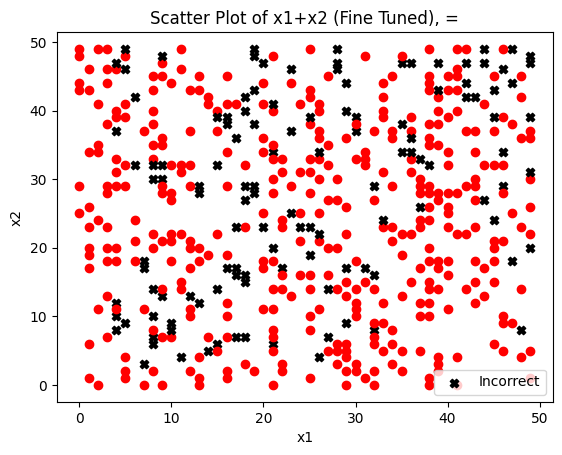

In [72]:
fig, ax = plt.subplots()
markers = {True: {'marker': 'o', 'label': 'Correct', 'color':'red'}, False: {'marker': 'X', 'label': 'Incorrect', 'color':'black'}}
legend_drawn = False
for i in range(len(X_test)):
    x1 = float(X_test[i].split("+")[0])
    x2 = float(X_test[i].split("+")[1].split("=")[0])
    marker = markers[y_binary[i]==1]
    ax.scatter(x1, x2, marker = marker['marker'], color=marker['color'], label=marker['label'])
    if not legend_drawn:
        ax.legend()
        legend_drawn = True

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('Scatter Plot of x1+x2 (Fine Tuned), =')
# ax.legend()
plt.show()

In [73]:
X_outside,y_outside = create_dataset(50,80)

In [74]:
input_strings_outside_range = encode_problems(X_outside, 'baseline')

['50+50=', '50+51=', '50+52=', '50+53=', '50+54=', '50+55=', '50+56=', '50+57=', '50+58=', '50+59=', '50+60=', '50+61=', '50+62=', '50+63=', '50+64=', '50+65=', '50+66=', '50+67=', '50+68=', '50+69=', '50+70=', '50+71=', '50+72=', '50+73=', '50+74=', '50+75=', '50+76=', '50+77=', '50+78=', '50+79=', '51+50=', '51+51=', '51+52=', '51+53=', '51+54=', '51+55=', '51+56=', '51+57=', '51+58=', '51+59=', '51+60=', '51+61=', '51+62=', '51+63=', '51+64=', '51+65=', '51+66=', '51+67=', '51+68=', '51+69=', '51+70=', '51+71=', '51+72=', '51+73=', '51+74=', '51+75=', '51+76=', '51+77=', '51+78=', '51+79=', '52+50=', '52+51=', '52+52=', '52+53=', '52+54=', '52+55=', '52+56=', '52+57=', '52+58=', '52+59=', '52+60=', '52+61=', '52+62=', '52+63=', '52+64=', '52+65=', '52+66=', '52+67=', '52+68=', '52+69=', '52+70=', '52+71=', '52+72=', '52+73=', '52+74=', '52+75=', '52+76=', '52+77=', '52+78=', '52+79=', '53+50=', '53+51=', '53+52=', '53+53=', '53+54=', '53+55=', '53+56=', '53+57=', '53+58=', '53+59=',

In [79]:
import numpy as np
count = 0
predicted_values = []
y_binary = []
pred_correct_values = []
for i in range(len(input_strings_outside_range)):
  s, probs, output = infer(input_strings_outside_range[i])
  print(i)
  true_val= y_outside[i].item()
  if s.split("<answer>: ")[1].split("<endofstring>")[0] == '':
    val = np.nan
    y_binary.append(0)
  else:
    val = s.split("<answer>: ")[1].split("<endofstring>")[0]
    if int(val) == true_val:
       pred_correct_values.append(val)
       count+=1
       y_binary.append(1)
    else:
      y_binary.append(0)
  predicted_values.append(val)
  # true_val= Y_test[i].item()
  print("Equation:", input_strings_outside_range[i])
  print("True Values:", true_val)
  print("Predicted Values:", val)

 


  # if pred_val>= true_val-3 and pred_val<= true_val+3:
  #   count+=1

print("Accuracy: ", (count*100)/len(X_test))
  
  

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0
Equation: 50+50=
True Values: 100
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1
Equation: 50+51=
True Values: 101
Predicted Values: 91 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2
Equation: 50+52=
True Values: 102
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


3
Equation: 50+53=
True Values: 103
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


4
Equation: 50+54=
True Values: 104
Predicted Values: 79 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


5
Equation: 50+55=
True Values: 105
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


6
Equation: 50+56=
True Values: 106
Predicted Values: 81 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


7
Equation: 50+57=
True Values: 107
Predicted Values: 81 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


8
Equation: 50+58=
True Values: 108
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


9
Equation: 50+59=
True Values: 109
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


10
Equation: 50+60=
True Values: 110
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


11
Equation: 50+61=
True Values: 111
Predicted Values: 81 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


12
Equation: 50+62=
True Values: 112
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


13
Equation: 50+63=
True Values: 113
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


14
Equation: 50+64=
True Values: 114
Predicted Values: 74 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


15
Equation: 50+65=
True Values: 115
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


16
Equation: 50+66=
True Values: 116
Predicted Values: 81 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


17
Equation: 50+67=
True Values: 117
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


18
Equation: 50+68=
True Values: 118
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


19
Equation: 50+69=
True Values: 119
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


20
Equation: 50+70=
True Values: 120
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


21
Equation: 50+71=
True Values: 121
Predicted Values: 81 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


22
Equation: 50+72=
True Values: 122
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


23
Equation: 50+73=
True Values: 123
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


24
Equation: 50+74=
True Values: 124
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


25
Equation: 50+75=
True Values: 125
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


26
Equation: 50+76=
True Values: 126
Predicted Values: 81 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


27
Equation: 50+77=
True Values: 127
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


28
Equation: 50+78=
True Values: 128
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


29
Equation: 50+79=
True Values: 129
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


30
Equation: 51+50=
True Values: 101
Predicted Values: 91 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


31
Equation: 51+51=
True Values: 102
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


32
Equation: 51+52=
True Values: 103
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


33
Equation: 51+53=
True Values: 104
Predicted Values: 94 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


34
Equation: 51+54=
True Values: 105
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


35
Equation: 51+55=
True Values: 106
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


36
Equation: 51+56=
True Values: 107
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


37
Equation: 51+57=
True Values: 108
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


38
Equation: 51+58=
True Values: 109
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


39
Equation: 51+59=
True Values: 110
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


40
Equation: 51+60=
True Values: 111
Predicted Values: 81 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


41
Equation: 51+61=
True Values: 112
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


42
Equation: 51+62=
True Values: 113
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


43
Equation: 51+63=
True Values: 114
Predicted Values: 74 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


44
Equation: 51+64=
True Values: 115
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


45
Equation: 51+65=
True Values: 116
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


46
Equation: 51+66=
True Values: 117
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


47
Equation: 51+67=
True Values: 118
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


48
Equation: 51+68=
True Values: 119
Predicted Values: 91 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


49
Equation: 51+69=
True Values: 120
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


50
Equation: 51+70=
True Values: 121
Predicted Values: 81 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


51
Equation: 51+71=
True Values: 122
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


52
Equation: 51+72=
True Values: 123
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


53
Equation: 51+73=
True Values: 124
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


54
Equation: 51+74=
True Values: 125
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


55
Equation: 51+75=
True Values: 126
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


56
Equation: 51+76=
True Values: 127
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


57
Equation: 51+77=
True Values: 128
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


58
Equation: 51+78=
True Values: 129
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


59
Equation: 51+79=
True Values: 130
Predicted Values: 90 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


60
Equation: 52+50=
True Values: 102
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


61
Equation: 52+51=
True Values: 103
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


62
Equation: 52+52=
True Values: 104
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


63
Equation: 52+53=
True Values: 105
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


64
Equation: 52+54=
True Values: 106
Predicted Values: 77 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


65
Equation: 52+55=
True Values: 107
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


66
Equation: 52+56=
True Values: 108
Predicted Values: 92 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


67
Equation: 52+57=
True Values: 109
Predicted Values: 90 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


68
Equation: 52+58=
True Values: 110
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


69
Equation: 52+59=
True Values: 111
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


70
Equation: 52+60=
True Values: 112
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


71
Equation: 52+61=
True Values: 113
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


72
Equation: 52+62=
True Values: 114
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


73
Equation: 52+63=
True Values: 115
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


74
Equation: 52+64=
True Values: 116
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


75
Equation: 52+65=
True Values: 117
Predicted Values: 81 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


76
Equation: 52+66=
True Values: 118
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


77
Equation: 52+67=
True Values: 119
Predicted Values: 90 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


78
Equation: 52+68=
True Values: 120
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


79
Equation: 52+69=
True Values: 121
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


80
Equation: 52+70=
True Values: 122
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


81
Equation: 52+71=
True Values: 123
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


82
Equation: 52+72=
True Values: 124
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


83
Equation: 52+73=
True Values: 125
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


84
Equation: 52+74=
True Values: 126
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


85
Equation: 52+75=
True Values: 127
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


86
Equation: 52+76=
True Values: 128
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


87
Equation: 52+77=
True Values: 129
Predicted Values: 94 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


88
Equation: 52+78=
True Values: 130
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


89
Equation: 52+79=
True Values: 131
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


90
Equation: 53+50=
True Values: 103
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


91
Equation: 53+51=
True Values: 104
Predicted Values: 78 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


92
Equation: 53+52=
True Values: 105
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


93
Equation: 53+53=
True Values: 106
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


94
Equation: 53+54=
True Values: 107
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


95
Equation: 53+55=
True Values: 108
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


96
Equation: 53+56=
True Values: 109
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


97
Equation: 53+57=
True Values: 110
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


98
Equation: 53+58=
True Values: 111
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


99
Equation: 53+59=
True Values: 112
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


100
Equation: 53+60=
True Values: 113
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


101
Equation: 53+61=
True Values: 114
Predicted Values: 78 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


102
Equation: 53+62=
True Values: 115
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


103
Equation: 53+63=
True Values: 116
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


104
Equation: 53+64=
True Values: 117
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


105
Equation: 53+65=
True Values: 118
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


106
Equation: 53+66=
True Values: 119
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


107
Equation: 53+67=
True Values: 120
Predicted Values: 90 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


108
Equation: 53+68=
True Values: 121
Predicted Values: 81 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


109
Equation: 53+69=
True Values: 122
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


110
Equation: 53+70=
True Values: 123
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


111
Equation: 53+71=
True Values: 124
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


112
Equation: 53+72=
True Values: 125
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


113
Equation: 53+73=
True Values: 126
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


114
Equation: 53+74=
True Values: 127
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


115
Equation: 53+75=
True Values: 128
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


116
Equation: 53+76=
True Values: 129
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


117
Equation: 53+77=
True Values: 130
Predicted Values: 94 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


118
Equation: 53+78=
True Values: 131
Predicted Values: 91 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


119
Equation: 53+79=
True Values: 132
Predicted Values: 92 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


120
Equation: 54+50=
True Values: 104
Predicted Values: 79 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


121
Equation: 54+51=
True Values: 105
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


122
Equation: 54+52=
True Values: 106
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


123
Equation: 54+53=
True Values: 107
Predicted Values: 77 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


124
Equation: 54+54=
True Values: 108
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


125
Equation: 54+55=
True Values: 109
Predicted Values: 79 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


126
Equation: 54+56=
True Values: 110
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


127
Equation: 54+57=
True Values: 111
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


128
Equation: 54+58=
True Values: 112
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


129
Equation: 54+59=
True Values: 113
Predicted Values: 78 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


130
Equation: 54+60=
True Values: 114
Predicted Values: 74 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


131
Equation: 54+61=
True Values: 115
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


132
Equation: 54+62=
True Values: 116
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


133
Equation: 54+63=
True Values: 117
Predicted Values: 81 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


134
Equation: 54+64=
True Values: 118
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


135
Equation: 54+65=
True Values: 119
Predicted Values: 81 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


136
Equation: 54+66=
True Values: 120
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


137
Equation: 54+67=
True Values: 121
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


138
Equation: 54+68=
True Values: 122
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


139
Equation: 54+69=
True Values: 123
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


140
Equation: 54+70=
True Values: 124
Predicted Values: 79 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


141
Equation: 54+71=
True Values: 125
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


142
Equation: 54+72=
True Values: 126
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


143
Equation: 54+73=
True Values: 127
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


144
Equation: 54+74=
True Values: 128
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


145
Equation: 54+75=
True Values: 129
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


146
Equation: 54+76=
True Values: 130
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


147
Equation: 54+77=
True Values: 131
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


148
Equation: 54+78=
True Values: 132
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


149
Equation: 54+79=
True Values: 133
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


150
Equation: 55+50=
True Values: 105
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


151
Equation: 55+51=
True Values: 106
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


152
Equation: 55+52=
True Values: 107
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


153
Equation: 55+53=
True Values: 108
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


154
Equation: 55+54=
True Values: 109
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


155
Equation: 55+55=
True Values: 110
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


156
Equation: 55+56=
True Values: 111
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


157
Equation: 55+57=
True Values: 112
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


158
Equation: 55+58=
True Values: 113
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


159
Equation: 55+59=
True Values: 114
Predicted Values: 78 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


160
Equation: 55+60=
True Values: 115
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


161
Equation: 55+61=
True Values: 116
Predicted Values: 76 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


162
Equation: 55+62=
True Values: 117
Predicted Values: 77 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


163
Equation: 55+63=
True Values: 118
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


164
Equation: 55+64=
True Values: 119
Predicted Values: 81 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


165
Equation: 55+65=
True Values: 120
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


166
Equation: 55+66=
True Values: 121
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


167
Equation: 55+67=
True Values: 122
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


168
Equation: 55+68=
True Values: 123
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


169
Equation: 55+69=
True Values: 124
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


170
Equation: 55+70=
True Values: 125
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


171
Equation: 55+71=
True Values: 126
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


172
Equation: 55+72=
True Values: 127
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


173
Equation: 55+73=
True Values: 128
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


174
Equation: 55+74=
True Values: 129
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


175
Equation: 55+75=
True Values: 130
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


176
Equation: 55+76=
True Values: 131
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


177
Equation: 55+77=
True Values: 132
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


178
Equation: 55+78=
True Values: 133
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


179
Equation: 55+79=
True Values: 134
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


180
Equation: 56+50=
True Values: 106
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


181
Equation: 56+51=
True Values: 107
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


182
Equation: 56+52=
True Values: 108
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


183
Equation: 56+53=
True Values: 109
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


184
Equation: 56+54=
True Values: 110
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


185
Equation: 56+55=
True Values: 111
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


186
Equation: 56+56=
True Values: 112
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


187
Equation: 56+57=
True Values: 113
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


188
Equation: 56+58=
True Values: 114
Predicted Values: 94 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


189
Equation: 56+59=
True Values: 115
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


190
Equation: 56+60=
True Values: 116
Predicted Values: 76 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


191
Equation: 56+61=
True Values: 117
Predicted Values: 77 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


192
Equation: 56+62=
True Values: 118
Predicted Values: 79 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


193
Equation: 56+63=
True Values: 119
Predicted Values: 79 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


194
Equation: 56+64=
True Values: 120
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


195
Equation: 56+65=
True Values: 121
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


196
Equation: 56+66=
True Values: 122
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


197
Equation: 56+67=
True Values: 123
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


198
Equation: 56+68=
True Values: 124
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


199
Equation: 56+69=
True Values: 125
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


200
Equation: 56+70=
True Values: 126
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


201
Equation: 56+71=
True Values: 127
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


202
Equation: 56+72=
True Values: 128
Predicted Values: 94 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


203
Equation: 56+73=
True Values: 129
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


204
Equation: 56+74=
True Values: 130
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


205
Equation: 56+75=
True Values: 131
Predicted Values: 81 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


206
Equation: 56+76=
True Values: 132
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


207
Equation: 56+77=
True Values: 133
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


208
Equation: 56+78=
True Values: 134
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


209
Equation: 56+79=
True Values: 135
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


210
Equation: 57+50=
True Values: 107
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


211
Equation: 57+51=
True Values: 108
Predicted Values: 78 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


212
Equation: 57+52=
True Values: 109
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


213
Equation: 57+53=
True Values: 110
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


214
Equation: 57+54=
True Values: 111
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


215
Equation: 57+55=
True Values: 112
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


216
Equation: 57+56=
True Values: 113
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


217
Equation: 57+57=
True Values: 114
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


218
Equation: 57+58=
True Values: 115
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


219
Equation: 57+59=
True Values: 116
Predicted Values: 76 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


220
Equation: 57+60=
True Values: 117
Predicted Values: 77 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


221
Equation: 57+61=
True Values: 118
Predicted Values: 78 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


222
Equation: 57+62=
True Values: 119
Predicted Values: 79 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


223
Equation: 57+63=
True Values: 120
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


224
Equation: 57+64=
True Values: 121
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


225
Equation: 57+65=
True Values: 122
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


226
Equation: 57+66=
True Values: 123
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


227
Equation: 57+67=
True Values: 124
Predicted Values: 90 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


228
Equation: 57+68=
True Values: 125
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


229
Equation: 57+69=
True Values: 126
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


230
Equation: 57+70=
True Values: 127
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


231
Equation: 57+71=
True Values: 128
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


232
Equation: 57+72=
True Values: 129
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


233
Equation: 57+73=
True Values: 130
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


234
Equation: 57+74=
True Values: 131
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


235
Equation: 57+75=
True Values: 132
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


236
Equation: 57+76=
True Values: 133
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


237
Equation: 57+77=
True Values: 134
Predicted Values: 94 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


238
Equation: 57+78=
True Values: 135
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


239
Equation: 57+79=
True Values: 136
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


240
Equation: 58+50=
True Values: 108
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


241
Equation: 58+51=
True Values: 109
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


242
Equation: 58+52=
True Values: 110
Predicted Values: 90 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


243
Equation: 58+53=
True Values: 111
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


244
Equation: 58+54=
True Values: 112
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


245
Equation: 58+55=
True Values: 113
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


246
Equation: 58+56=
True Values: 114
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


247
Equation: 58+57=
True Values: 115
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


248
Equation: 58+58=
True Values: 116
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


249
Equation: 58+59=
True Values: 117
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


250
Equation: 58+60=
True Values: 118
Predicted Values: 78 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


251
Equation: 58+61=
True Values: 119
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


252
Equation: 58+62=
True Values: 120
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


253
Equation: 58+63=
True Values: 121
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


254
Equation: 58+64=
True Values: 122
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


255
Equation: 58+65=
True Values: 123
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


256
Equation: 58+66=
True Values: 124
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


257
Equation: 58+67=
True Values: 125
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


258
Equation: 58+68=
True Values: 126
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


259
Equation: 58+69=
True Values: 127
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


260
Equation: 58+70=
True Values: 128
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


261
Equation: 58+71=
True Values: 129
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


262
Equation: 58+72=
True Values: 130
Predicted Values: 90 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


263
Equation: 58+73=
True Values: 131
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


264
Equation: 58+74=
True Values: 132
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


265
Equation: 58+75=
True Values: 133
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


266
Equation: 58+76=
True Values: 134
Predicted Values: 94 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


267
Equation: 58+77=
True Values: 135
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


268
Equation: 58+78=
True Values: 136
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


269
Equation: 58+79=
True Values: 137
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


270
Equation: 59+50=
True Values: 109
Predicted Values: 79 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


271
Equation: 59+51=
True Values: 110
Predicted Values: 90 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


272
Equation: 59+52=
True Values: 111
Predicted Values: 91 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


273
Equation: 59+53=
True Values: 112
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


274
Equation: 59+54=
True Values: 113
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


275
Equation: 59+55=
True Values: 114
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


276
Equation: 59+56=
True Values: 115
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


277
Equation: 59+57=
True Values: 116
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


278
Equation: 59+58=
True Values: 117
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


279
Equation: 59+59=
True Values: 118
Predicted Values: 78 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


280
Equation: 59+60=
True Values: 119
Predicted Values: 79 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


281
Equation: 59+61=
True Values: 120
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


282
Equation: 59+62=
True Values: 121
Predicted Values: 81 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


283
Equation: 59+63=
True Values: 122
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


284
Equation: 59+64=
True Values: 123
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


285
Equation: 59+65=
True Values: 124
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


286
Equation: 59+66=
True Values: 125
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


287
Equation: 59+67=
True Values: 126
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


288
Equation: 59+68=
True Values: 127
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


289
Equation: 59+69=
True Values: 128
Predicted Values: 78 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


290
Equation: 59+70=
True Values: 129
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


291
Equation: 59+71=
True Values: 130
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


292
Equation: 59+72=
True Values: 131
Predicted Values: 91 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


293
Equation: 59+73=
True Values: 132
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


294
Equation: 59+74=
True Values: 133
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


295
Equation: 59+75=
True Values: 134
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


296
Equation: 59+76=
True Values: 135
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


297
Equation: 59+77=
True Values: 136
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


298
Equation: 59+78=
True Values: 137
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


299
Equation: 59+79=
True Values: 138
Predicted Values: 78 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


300
Equation: 60+50=
True Values: 110
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


301
Equation: 60+51=
True Values: 111
Predicted Values: 81 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


302
Equation: 60+52=
True Values: 112
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


303
Equation: 60+53=
True Values: 113
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


304
Equation: 60+54=
True Values: 114
Predicted Values: 79 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


305
Equation: 60+55=
True Values: 115
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


306
Equation: 60+56=
True Values: 116
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


307
Equation: 60+57=
True Values: 117
Predicted Values: 77 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


308
Equation: 60+58=
True Values: 118
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


309
Equation: 60+59=
True Values: 119
Predicted Values: 79 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


310
Equation: 60+60=
True Values: 120
Predicted Values: 70 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


311
Equation: 60+61=
True Values: 121
Predicted Values: 81 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


312
Equation: 60+62=
True Values: 122
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


313
Equation: 60+63=
True Values: 123
Predicted Values: 73 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


314
Equation: 60+64=
True Values: 124
Predicted Values: 74 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


315
Equation: 60+65=
True Values: 125
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


316
Equation: 60+66=
True Values: 126
Predicted Values: 76 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


317
Equation: 60+67=
True Values: 127
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


318
Equation: 60+68=
True Values: 128
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


319
Equation: 60+69=
True Values: 129
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


320
Equation: 60+70=
True Values: 130
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


321
Equation: 60+71=
True Values: 131
Predicted Values: 81 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


322
Equation: 60+72=
True Values: 132
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


323
Equation: 60+73=
True Values: 133
Predicted Values: 77 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


324
Equation: 60+74=
True Values: 134
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


325
Equation: 60+75=
True Values: 135
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


326
Equation: 60+76=
True Values: 136
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


327
Equation: 60+77=
True Values: 137
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


328
Equation: 60+78=
True Values: 138
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


329
Equation: 60+79=
True Values: 139
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


330
Equation: 61+50=
True Values: 111
Predicted Values: 81 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


331
Equation: 61+51=
True Values: 112
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


332
Equation: 61+52=
True Values: 113
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


333
Equation: 61+53=
True Values: 114
Predicted Values: 74 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


334
Equation: 61+54=
True Values: 115
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


335
Equation: 61+55=
True Values: 116
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


336
Equation: 61+56=
True Values: 117
Predicted Values: 81 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


337
Equation: 61+57=
True Values: 118
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


338
Equation: 61+58=
True Values: 119
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


339
Equation: 61+59=
True Values: 120
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


340
Equation: 61+60=
True Values: 121
Predicted Values: 71 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


341
Equation: 61+61=
True Values: 122
Predicted Values: 72 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


342
Equation: 61+62=
True Values: 123
Predicted Values: 73 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


343
Equation: 61+63=
True Values: 124
Predicted Values: 74 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


344
Equation: 61+64=
True Values: 125
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


345
Equation: 61+65=
True Values: 126
Predicted Values: 76 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


346
Equation: 61+66=
True Values: 127
Predicted Values: 81 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


347
Equation: 61+67=
True Values: 128
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


348
Equation: 61+68=
True Values: 129
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


349
Equation: 61+69=
True Values: 130
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


350
Equation: 61+70=
True Values: 131
Predicted Values: 81 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


351
Equation: 61+71=
True Values: 132
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


352
Equation: 61+72=
True Values: 133
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


353
Equation: 61+73=
True Values: 134
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


354
Equation: 61+74=
True Values: 135
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


355
Equation: 61+75=
True Values: 136
Predicted Values: 76 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


356
Equation: 61+76=
True Values: 137
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


357
Equation: 61+77=
True Values: 138
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


358
Equation: 61+78=
True Values: 139
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


359
Equation: 61+79=
True Values: 140
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


360
Equation: 62+50=
True Values: 112
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


361
Equation: 62+51=
True Values: 113
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


362
Equation: 62+52=
True Values: 114
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


363
Equation: 62+53=
True Values: 115
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


364
Equation: 62+54=
True Values: 116
Predicted Values: 76 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


365
Equation: 62+55=
True Values: 117
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


366
Equation: 62+56=
True Values: 118
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


367
Equation: 62+57=
True Values: 119
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


368
Equation: 62+58=
True Values: 120
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


369
Equation: 62+59=
True Values: 121
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


370
Equation: 62+60=
True Values: 122
Predicted Values: 72 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


371
Equation: 62+61=
True Values: 123
Predicted Values: 73 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


372
Equation: 62+62=
True Values: 124
Predicted Values: 74 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


373
Equation: 62+63=
True Values: 125
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


374
Equation: 62+64=
True Values: 126
Predicted Values: 76 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


375
Equation: 62+65=
True Values: 127
Predicted Values: 81 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


376
Equation: 62+66=
True Values: 128
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


377
Equation: 62+67=
True Values: 129
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


378
Equation: 62+68=
True Values: 130
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


379
Equation: 62+69=
True Values: 131
Predicted Values: 81 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


380
Equation: 62+70=
True Values: 132
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


381
Equation: 62+71=
True Values: 133
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


382
Equation: 62+72=
True Values: 134
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


383
Equation: 62+73=
True Values: 135
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


384
Equation: 62+74=
True Values: 136
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


385
Equation: 62+75=
True Values: 137
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


386
Equation: 62+76=
True Values: 138
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


387
Equation: 62+77=
True Values: 139
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


388
Equation: 62+78=
True Values: 140
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


389
Equation: 62+79=
True Values: 141
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


390
Equation: 63+50=
True Values: 113
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


391
Equation: 63+51=
True Values: 114
Predicted Values: 78 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


392
Equation: 63+52=
True Values: 115
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


393
Equation: 63+53=
True Values: 116
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


394
Equation: 63+54=
True Values: 117
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


395
Equation: 63+55=
True Values: 118
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


396
Equation: 63+56=
True Values: 119
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


397
Equation: 63+57=
True Values: 120
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


398
Equation: 63+58=
True Values: 121
Predicted Values: 81 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


399
Equation: 63+59=
True Values: 122
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


400
Equation: 63+60=
True Values: 123
Predicted Values: 77 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


401
Equation: 63+61=
True Values: 124
Predicted Values: 78 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


402
Equation: 63+62=
True Values: 125
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


403
Equation: 63+63=
True Values: 126
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


404
Equation: 63+64=
True Values: 127
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


405
Equation: 63+65=
True Values: 128
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


406
Equation: 63+66=
True Values: 129
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


407
Equation: 63+67=
True Values: 130
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


408
Equation: 63+68=
True Values: 131
Predicted Values: 81 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


409
Equation: 63+69=
True Values: 132
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


410
Equation: 63+70=
True Values: 133
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


411
Equation: 63+71=
True Values: 134
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


412
Equation: 63+72=
True Values: 135
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


413
Equation: 63+73=
True Values: 136
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


414
Equation: 63+74=
True Values: 137
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


415
Equation: 63+75=
True Values: 138
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


416
Equation: 63+76=
True Values: 139
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


417
Equation: 63+77=
True Values: 140
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


418
Equation: 63+78=
True Values: 141
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


419
Equation: 63+79=
True Values: 142
Predicted Values: 92 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


420
Equation: 64+50=
True Values: 114
Predicted Values: 79 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


421
Equation: 64+51=
True Values: 115
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


422
Equation: 64+52=
True Values: 116
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


423
Equation: 64+53=
True Values: 117
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


424
Equation: 64+54=
True Values: 118
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


425
Equation: 64+55=
True Values: 119
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


426
Equation: 64+56=
True Values: 120
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


427
Equation: 64+57=
True Values: 121
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


428
Equation: 64+58=
True Values: 122
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


429
Equation: 64+59=
True Values: 123
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


430
Equation: 64+60=
True Values: 124
Predicted Values: 74 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


431
Equation: 64+61=
True Values: 125
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


432
Equation: 64+62=
True Values: 126
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


433
Equation: 64+63=
True Values: 127
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


434
Equation: 64+64=
True Values: 128
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


435
Equation: 64+65=
True Values: 129
Predicted Values: 81 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


436
Equation: 64+66=
True Values: 130
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


437
Equation: 64+67=
True Values: 131
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


438
Equation: 64+68=
True Values: 132
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


439
Equation: 64+69=
True Values: 133
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


440
Equation: 64+70=
True Values: 134
Predicted Values: 74 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


441
Equation: 64+71=
True Values: 135
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


442
Equation: 64+72=
True Values: 136
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


443
Equation: 64+73=
True Values: 137
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


444
Equation: 64+74=
True Values: 138
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


445
Equation: 64+75=
True Values: 139
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


446
Equation: 64+76=
True Values: 140
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


447
Equation: 64+77=
True Values: 141
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


448
Equation: 64+78=
True Values: 142
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


449
Equation: 64+79=
True Values: 143
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


450
Equation: 65+50=
True Values: 115
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


451
Equation: 65+51=
True Values: 116
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


452
Equation: 65+52=
True Values: 117
Predicted Values: 77 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


453
Equation: 65+53=
True Values: 118
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


454
Equation: 65+54=
True Values: 119
Predicted Values: 81 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


455
Equation: 65+55=
True Values: 120
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


456
Equation: 65+56=
True Values: 121
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


457
Equation: 65+57=
True Values: 122
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


458
Equation: 65+58=
True Values: 123
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


459
Equation: 65+59=
True Values: 124
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


460
Equation: 65+60=
True Values: 125
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


461
Equation: 65+61=
True Values: 126
Predicted Values: 76 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


462
Equation: 65+62=
True Values: 127
Predicted Values: 77 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


463
Equation: 65+63=
True Values: 128
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


464
Equation: 65+64=
True Values: 129
Predicted Values: 81 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


465
Equation: 65+65=
True Values: 130
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


466
Equation: 65+66=
True Values: 131
Predicted Values: 81 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


467
Equation: 65+67=
True Values: 132
Predicted Values: 90 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


468
Equation: 65+68=
True Values: 133
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


469
Equation: 65+69=
True Values: 134
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


470
Equation: 65+70=
True Values: 135
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


471
Equation: 65+71=
True Values: 136
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


472
Equation: 65+72=
True Values: 137
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


473
Equation: 65+73=
True Values: 138
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


474
Equation: 65+74=
True Values: 139
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


475
Equation: 65+75=
True Values: 140
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


476
Equation: 65+76=
True Values: 141
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


477
Equation: 65+77=
True Values: 142
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


478
Equation: 65+78=
True Values: 143
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


479
Equation: 65+79=
True Values: 144
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


480
Equation: 66+50=
True Values: 116
Predicted Values: 76 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


481
Equation: 66+51=
True Values: 117
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


482
Equation: 66+52=
True Values: 118
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


483
Equation: 66+53=
True Values: 119
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


484
Equation: 66+54=
True Values: 120
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


485
Equation: 66+55=
True Values: 121
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


486
Equation: 66+56=
True Values: 122
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


487
Equation: 66+57=
True Values: 123
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


488
Equation: 66+58=
True Values: 124
Predicted Values: 94 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


489
Equation: 66+59=
True Values: 125
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


490
Equation: 66+60=
True Values: 126
Predicted Values: 76 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


491
Equation: 66+61=
True Values: 127
Predicted Values: 77 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


492
Equation: 66+62=
True Values: 128
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


493
Equation: 66+63=
True Values: 129
Predicted Values: 79 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


494
Equation: 66+64=
True Values: 130
Predicted Values: 76 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


495
Equation: 66+65=
True Values: 131
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


496
Equation: 66+66=
True Values: 132
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


497
Equation: 66+67=
True Values: 133
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


498
Equation: 66+68=
True Values: 134
Predicted Values: 94 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


499
Equation: 66+69=
True Values: 135
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


500
Equation: 66+70=
True Values: 136
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


501
Equation: 66+71=
True Values: 137
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


502
Equation: 66+72=
True Values: 138
Predicted Values: 94 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


503
Equation: 66+73=
True Values: 139
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


504
Equation: 66+74=
True Values: 140
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


505
Equation: 66+75=
True Values: 141
Predicted Values: 81 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


506
Equation: 66+76=
True Values: 142
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


507
Equation: 66+77=
True Values: 143
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


508
Equation: 66+78=
True Values: 144
Predicted Values: 94 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


509
Equation: 66+79=
True Values: 145
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


510
Equation: 67+50=
True Values: 117
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


511
Equation: 67+51=
True Values: 118
Predicted Values: 78 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


512
Equation: 67+52=
True Values: 119
Predicted Values: 79 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


513
Equation: 67+53=
True Values: 120
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


514
Equation: 67+54=
True Values: 121
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


515
Equation: 67+55=
True Values: 122
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


516
Equation: 67+56=
True Values: 123
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


517
Equation: 67+57=
True Values: 124
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


518
Equation: 67+58=
True Values: 125
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


519
Equation: 67+59=
True Values: 126
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


520
Equation: 67+60=
True Values: 127
Predicted Values: 77 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


521
Equation: 67+61=
True Values: 128
Predicted Values: 78 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


522
Equation: 67+62=
True Values: 129
Predicted Values: 79 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


523
Equation: 67+63=
True Values: 130
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


524
Equation: 67+64=
True Values: 131
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


525
Equation: 67+65=
True Values: 132
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


526
Equation: 67+66=
True Values: 133
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


527
Equation: 67+67=
True Values: 134
Predicted Values: 90 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


528
Equation: 67+68=
True Values: 135
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


529
Equation: 67+69=
True Values: 136
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


530
Equation: 67+70=
True Values: 137
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


531
Equation: 67+71=
True Values: 138
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


532
Equation: 67+72=
True Values: 139
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


533
Equation: 67+73=
True Values: 140
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


534
Equation: 67+74=
True Values: 141
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


535
Equation: 67+75=
True Values: 142
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


536
Equation: 67+76=
True Values: 143
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


537
Equation: 67+77=
True Values: 144
Predicted Values: 94 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


538
Equation: 67+78=
True Values: 145
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


539
Equation: 67+79=
True Values: 146
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


540
Equation: 68+50=
True Values: 118
Predicted Values: 78 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


541
Equation: 68+51=
True Values: 119
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


542
Equation: 68+52=
True Values: 120
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


543
Equation: 68+53=
True Values: 121
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


544
Equation: 68+54=
True Values: 122
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


545
Equation: 68+55=
True Values: 123
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


546
Equation: 68+56=
True Values: 124
Predicted Values: 94 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


547
Equation: 68+57=
True Values: 125
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


548
Equation: 68+58=
True Values: 126
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


549
Equation: 68+59=
True Values: 127
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


550
Equation: 68+60=
True Values: 128
Predicted Values: 78 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


551
Equation: 68+61=
True Values: 129
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


552
Equation: 68+62=
True Values: 130
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


553
Equation: 68+63=
True Values: 131
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


554
Equation: 68+64=
True Values: 132
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


555
Equation: 68+65=
True Values: 133
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


556
Equation: 68+66=
True Values: 134
Predicted Values: 94 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


557
Equation: 68+67=
True Values: 135
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


558
Equation: 68+68=
True Values: 136
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


559
Equation: 68+69=
True Values: 137
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


560
Equation: 68+70=
True Values: 138
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


561
Equation: 68+71=
True Values: 139
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


562
Equation: 68+72=
True Values: 140
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


563
Equation: 68+73=
True Values: 141
Predicted Values: 91 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


564
Equation: 68+74=
True Values: 142
Predicted Values: 92 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


565
Equation: 68+75=
True Values: 143
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


566
Equation: 68+76=
True Values: 144
Predicted Values: 94 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


567
Equation: 68+77=
True Values: 145
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


568
Equation: 68+78=
True Values: 146
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


569
Equation: 68+79=
True Values: 147
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


570
Equation: 69+50=
True Values: 119
Predicted Values: 79 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


571
Equation: 69+51=
True Values: 120
Predicted Values: 90 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


572
Equation: 69+52=
True Values: 121
Predicted Values: 91 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


573
Equation: 69+53=
True Values: 122
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


574
Equation: 69+54=
True Values: 123
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


575
Equation: 69+55=
True Values: 124
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


576
Equation: 69+56=
True Values: 125
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


577
Equation: 69+57=
True Values: 126
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


578
Equation: 69+58=
True Values: 127
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


579
Equation: 69+59=
True Values: 128
Predicted Values: 78 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


580
Equation: 69+60=
True Values: 129
Predicted Values: 79 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


581
Equation: 69+61=
True Values: 130
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


582
Equation: 69+62=
True Values: 131
Predicted Values: 81 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


583
Equation: 69+63=
True Values: 132
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


584
Equation: 69+64=
True Values: 133
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


585
Equation: 69+65=
True Values: 134
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


586
Equation: 69+66=
True Values: 135
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


587
Equation: 69+67=
True Values: 136
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


588
Equation: 69+68=
True Values: 137
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


589
Equation: 69+69=
True Values: 138
Predicted Values: 78 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


590
Equation: 69+70=
True Values: 139
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


591
Equation: 69+71=
True Values: 140
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


592
Equation: 69+72=
True Values: 141
Predicted Values: 91 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


593
Equation: 69+73=
True Values: 142
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


594
Equation: 69+74=
True Values: 143
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


595
Equation: 69+75=
True Values: 144
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


596
Equation: 69+76=
True Values: 145
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


597
Equation: 69+77=
True Values: 146
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


598
Equation: 69+78=
True Values: 147
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


599
Equation: 69+79=
True Values: 148
Predicted Values: 78 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


600
Equation: 70+50=
True Values: 120
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


601
Equation: 70+51=
True Values: 121
Predicted Values: 81 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


602
Equation: 70+52=
True Values: 122
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


603
Equation: 70+53=
True Values: 123
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


604
Equation: 70+54=
True Values: 124
Predicted Values: 79 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


605
Equation: 70+55=
True Values: 125
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


606
Equation: 70+56=
True Values: 126
Predicted Values: 81 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


607
Equation: 70+57=
True Values: 127
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


608
Equation: 70+58=
True Values: 128
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


609
Equation: 70+59=
True Values: 129
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


610
Equation: 70+60=
True Values: 130
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


611
Equation: 70+61=
True Values: 131
Predicted Values: 81 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


612
Equation: 70+62=
True Values: 132
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


613
Equation: 70+63=
True Values: 133
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


614
Equation: 70+64=
True Values: 134
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


615
Equation: 70+65=
True Values: 135
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


616
Equation: 70+66=
True Values: 136
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


617
Equation: 70+67=
True Values: 137
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


618
Equation: 70+68=
True Values: 138
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


619
Equation: 70+69=
True Values: 139
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


620
Equation: 70+70=
True Values: 140
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


621
Equation: 70+71=
True Values: 141
Predicted Values: 81 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


622
Equation: 70+72=
True Values: 142
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


623
Equation: 70+73=
True Values: 143
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


624
Equation: 70+74=
True Values: 144
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


625
Equation: 70+75=
True Values: 145
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


626
Equation: 70+76=
True Values: 146
Predicted Values: 81 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


627
Equation: 70+77=
True Values: 147
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


628
Equation: 70+78=
True Values: 148
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


629
Equation: 70+79=
True Values: 149
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


630
Equation: 71+50=
True Values: 121
Predicted Values: 81 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


631
Equation: 71+51=
True Values: 122
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


632
Equation: 71+52=
True Values: 123
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


633
Equation: 71+53=
True Values: 124
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


634
Equation: 71+54=
True Values: 125
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


635
Equation: 71+55=
True Values: 126
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


636
Equation: 71+56=
True Values: 127
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


637
Equation: 71+57=
True Values: 128
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


638
Equation: 71+58=
True Values: 129
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


639
Equation: 71+59=
True Values: 130
Predicted Values: 76 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


640
Equation: 71+60=
True Values: 131
Predicted Values: 71 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


641
Equation: 71+61=
True Values: 132
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


642
Equation: 71+62=
True Values: 133
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


643
Equation: 71+63=
True Values: 134
Predicted Values: 74 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


644
Equation: 71+64=
True Values: 135
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


645
Equation: 71+65=
True Values: 136
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


646
Equation: 71+66=
True Values: 137
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


647
Equation: 71+67=
True Values: 138
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


648
Equation: 71+68=
True Values: 139
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


649
Equation: 71+69=
True Values: 140
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


650
Equation: 71+70=
True Values: 141
Predicted Values: 81 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


651
Equation: 71+71=
True Values: 142
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


652
Equation: 71+72=
True Values: 143
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


653
Equation: 71+73=
True Values: 144
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


654
Equation: 71+74=
True Values: 145
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


655
Equation: 71+75=
True Values: 146
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


656
Equation: 71+76=
True Values: 147
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


657
Equation: 71+77=
True Values: 148
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


658
Equation: 71+78=
True Values: 149
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


659
Equation: 71+79=
True Values: 150
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


660
Equation: 72+50=
True Values: 122
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


661
Equation: 72+51=
True Values: 123
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


662
Equation: 72+52=
True Values: 124
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


663
Equation: 72+53=
True Values: 125
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


664
Equation: 72+54=
True Values: 126
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


665
Equation: 72+55=
True Values: 127
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


666
Equation: 72+56=
True Values: 128
Predicted Values: 94 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


667
Equation: 72+57=
True Values: 129
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


668
Equation: 72+58=
True Values: 130
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


669
Equation: 72+59=
True Values: 131
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


670
Equation: 72+60=
True Values: 132
Predicted Values: 72 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


671
Equation: 72+61=
True Values: 133
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


672
Equation: 72+62=
True Values: 134
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


673
Equation: 72+63=
True Values: 135
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


674
Equation: 72+64=
True Values: 136
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


675
Equation: 72+65=
True Values: 137
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


676
Equation: 72+66=
True Values: 138
Predicted Values: 94 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


677
Equation: 72+67=
True Values: 139
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


678
Equation: 72+68=
True Values: 140
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


679
Equation: 72+69=
True Values: 141
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


680
Equation: 72+70=
True Values: 142
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


681
Equation: 72+71=
True Values: 143
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


682
Equation: 72+72=
True Values: 144
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


683
Equation: 72+73=
True Values: 145
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


684
Equation: 72+74=
True Values: 146
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


685
Equation: 72+75=
True Values: 147
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


686
Equation: 72+76=
True Values: 148
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


687
Equation: 72+77=
True Values: 149
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


688
Equation: 72+78=
True Values: 150
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


689
Equation: 72+79=
True Values: 151
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


690
Equation: 73+50=
True Values: 123
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


691
Equation: 73+51=
True Values: 124
Predicted Values: 78 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


692
Equation: 73+52=
True Values: 125
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


693
Equation: 73+53=
True Values: 126
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


694
Equation: 73+54=
True Values: 127
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


695
Equation: 73+55=
True Values: 128
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


696
Equation: 73+56=
True Values: 129
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


697
Equation: 73+57=
True Values: 130
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


698
Equation: 73+58=
True Values: 131
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


699
Equation: 73+59=
True Values: 132
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


700
Equation: 73+60=
True Values: 133
Predicted Values: 73 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


701
Equation: 73+61=
True Values: 134
Predicted Values: 78 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


702
Equation: 73+62=
True Values: 135
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


703
Equation: 73+63=
True Values: 136
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


704
Equation: 73+64=
True Values: 137
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


705
Equation: 73+65=
True Values: 138
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


706
Equation: 73+66=
True Values: 139
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


707
Equation: 73+67=
True Values: 140
Predicted Values: 90 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


708
Equation: 73+68=
True Values: 141
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


709
Equation: 73+69=
True Values: 142
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


710
Equation: 73+70=
True Values: 143
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


711
Equation: 73+71=
True Values: 144
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


712
Equation: 73+72=
True Values: 145
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


713
Equation: 73+73=
True Values: 146
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


714
Equation: 73+74=
True Values: 147
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


715
Equation: 73+75=
True Values: 148
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


716
Equation: 73+76=
True Values: 149
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


717
Equation: 73+77=
True Values: 150
Predicted Values: 94 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


718
Equation: 73+78=
True Values: 151
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


719
Equation: 73+79=
True Values: 152
Predicted Values: 92 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


720
Equation: 74+50=
True Values: 124
Predicted Values: 74 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


721
Equation: 74+51=
True Values: 125
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


722
Equation: 74+52=
True Values: 126
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


723
Equation: 74+53=
True Values: 127
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


724
Equation: 74+54=
True Values: 128
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


725
Equation: 74+55=
True Values: 129
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


726
Equation: 74+56=
True Values: 130
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


727
Equation: 74+57=
True Values: 131
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


728
Equation: 74+58=
True Values: 132
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


729
Equation: 74+59=
True Values: 133
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


730
Equation: 74+60=
True Values: 134
Predicted Values: 74 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


731
Equation: 74+61=
True Values: 135
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


732
Equation: 74+62=
True Values: 136
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


733
Equation: 74+63=
True Values: 137
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


734
Equation: 74+64=
True Values: 138
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


735
Equation: 74+65=
True Values: 139
Predicted Values: 81 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


736
Equation: 74+66=
True Values: 140
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


737
Equation: 74+67=
True Values: 141
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


738
Equation: 74+68=
True Values: 142
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


739
Equation: 74+69=
True Values: 143
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


740
Equation: 74+70=
True Values: 144
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


741
Equation: 74+71=
True Values: 145
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


742
Equation: 74+72=
True Values: 146
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


743
Equation: 74+73=
True Values: 147
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


744
Equation: 74+74=
True Values: 148
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


745
Equation: 74+75=
True Values: 149
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


746
Equation: 74+76=
True Values: 150
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


747
Equation: 74+77=
True Values: 151
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


748
Equation: 74+78=
True Values: 152
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


749
Equation: 74+79=
True Values: 153
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


750
Equation: 75+50=
True Values: 125
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


751
Equation: 75+51=
True Values: 126
Predicted Values: 76 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


752
Equation: 75+52=
True Values: 127
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


753
Equation: 75+53=
True Values: 128
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


754
Equation: 75+54=
True Values: 129
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


755
Equation: 75+55=
True Values: 130
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


756
Equation: 75+56=
True Values: 131
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


757
Equation: 75+57=
True Values: 132
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


758
Equation: 75+58=
True Values: 133
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


759
Equation: 75+59=
True Values: 134
Predicted Values: 78 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


760
Equation: 75+60=
True Values: 135
Predicted Values: 75 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


761
Equation: 75+61=
True Values: 136
Predicted Values: 76 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


762
Equation: 75+62=
True Values: 137
Predicted Values: 79 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


763
Equation: 75+63=
True Values: 138
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


764
Equation: 75+64=
True Values: 139
Predicted Values: 81 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


765
Equation: 75+65=
True Values: 140
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


766
Equation: 75+66=
True Values: 141
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


767
Equation: 75+67=
True Values: 142
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


768
Equation: 75+68=
True Values: 143
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


769
Equation: 75+69=
True Values: 144
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


770
Equation: 75+70=
True Values: 145
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


771
Equation: 75+71=
True Values: 146
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


772
Equation: 75+72=
True Values: 147
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


773
Equation: 75+73=
True Values: 148
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


774
Equation: 75+74=
True Values: 149
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


775
Equation: 75+75=
True Values: 150
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


776
Equation: 75+76=
True Values: 151
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


777
Equation: 75+77=
True Values: 152
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


778
Equation: 75+78=
True Values: 153
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


779
Equation: 75+79=
True Values: 154
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


780
Equation: 76+50=
True Values: 126
Predicted Values: 76 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


781
Equation: 76+51=
True Values: 127
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


782
Equation: 76+52=
True Values: 128
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


783
Equation: 76+53=
True Values: 129
Predicted Values: 79 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


784
Equation: 76+54=
True Values: 130
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


785
Equation: 76+55=
True Values: 131
Predicted Values: 81 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


786
Equation: 76+56=
True Values: 132
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


787
Equation: 76+57=
True Values: 133
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


788
Equation: 76+58=
True Values: 134
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


789
Equation: 76+59=
True Values: 135
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


790
Equation: 76+60=
True Values: 136
Predicted Values: 76 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


791
Equation: 76+61=
True Values: 137
Predicted Values: 77 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


792
Equation: 76+62=
True Values: 138
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


793
Equation: 76+63=
True Values: 139
Predicted Values: 79 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


794
Equation: 76+64=
True Values: 140
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


795
Equation: 76+65=
True Values: 141
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


796
Equation: 76+66=
True Values: 142
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


797
Equation: 76+67=
True Values: 143
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


798
Equation: 76+68=
True Values: 144
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


799
Equation: 76+69=
True Values: 145
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


800
Equation: 76+70=
True Values: 146
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


801
Equation: 76+71=
True Values: 147
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


802
Equation: 76+72=
True Values: 148
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


803
Equation: 76+73=
True Values: 149
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


804
Equation: 76+74=
True Values: 150
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


805
Equation: 76+75=
True Values: 151
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


806
Equation: 76+76=
True Values: 152
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


807
Equation: 76+77=
True Values: 153
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


808
Equation: 76+78=
True Values: 154
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


809
Equation: 76+79=
True Values: 155
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


810
Equation: 77+50=
True Values: 127
Predicted Values: 77 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


811
Equation: 77+51=
True Values: 128
Predicted Values: 78 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


812
Equation: 77+52=
True Values: 129
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


813
Equation: 77+53=
True Values: 130
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


814
Equation: 77+54=
True Values: 131
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


815
Equation: 77+55=
True Values: 132
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


816
Equation: 77+56=
True Values: 133
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


817
Equation: 77+57=
True Values: 134
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


818
Equation: 77+58=
True Values: 135
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


819
Equation: 77+59=
True Values: 136
Predicted Values: 76 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


820
Equation: 77+60=
True Values: 137
Predicted Values: 77 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


821
Equation: 77+61=
True Values: 138
Predicted Values: 78 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


822
Equation: 77+62=
True Values: 139
Predicted Values: 79 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


823
Equation: 77+63=
True Values: 140
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


824
Equation: 77+64=
True Values: 141
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


825
Equation: 77+65=
True Values: 142
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


826
Equation: 77+66=
True Values: 143
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


827
Equation: 77+67=
True Values: 144
Predicted Values: 90 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


828
Equation: 77+68=
True Values: 145
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


829
Equation: 77+69=
True Values: 146
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


830
Equation: 77+70=
True Values: 147
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


831
Equation: 77+71=
True Values: 148
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


832
Equation: 77+72=
True Values: 149
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


833
Equation: 77+73=
True Values: 150
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


834
Equation: 77+74=
True Values: 151
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


835
Equation: 77+75=
True Values: 152
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


836
Equation: 77+76=
True Values: 153
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


837
Equation: 77+77=
True Values: 154
Predicted Values: 94 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


838
Equation: 77+78=
True Values: 155
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


839
Equation: 77+79=
True Values: 156
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


840
Equation: 78+50=
True Values: 128
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


841
Equation: 78+51=
True Values: 129
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


842
Equation: 78+52=
True Values: 130
Predicted Values: 90 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


843
Equation: 78+53=
True Values: 131
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


844
Equation: 78+54=
True Values: 132
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


845
Equation: 78+55=
True Values: 133
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


846
Equation: 78+56=
True Values: 134
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


847
Equation: 78+57=
True Values: 135
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


848
Equation: 78+58=
True Values: 136
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


849
Equation: 78+59=
True Values: 137
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


850
Equation: 78+60=
True Values: 138
Predicted Values: 78 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


851
Equation: 78+61=
True Values: 139
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


852
Equation: 78+62=
True Values: 140
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


853
Equation: 78+63=
True Values: 141
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


854
Equation: 78+64=
True Values: 142
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


855
Equation: 78+65=
True Values: 143
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


856
Equation: 78+66=
True Values: 144
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


857
Equation: 78+67=
True Values: 145
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


858
Equation: 78+68=
True Values: 146
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


859
Equation: 78+69=
True Values: 147
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


860
Equation: 78+70=
True Values: 148
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


861
Equation: 78+71=
True Values: 149
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


862
Equation: 78+72=
True Values: 150
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


863
Equation: 78+73=
True Values: 151
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


864
Equation: 78+74=
True Values: 152
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


865
Equation: 78+75=
True Values: 153
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


866
Equation: 78+76=
True Values: 154
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


867
Equation: 78+77=
True Values: 155
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


868
Equation: 78+78=
True Values: 156
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


869
Equation: 78+79=
True Values: 157
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


870
Equation: 79+50=
True Values: 129
Predicted Values: 79 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


871
Equation: 79+51=
True Values: 130
Predicted Values: 90 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


872
Equation: 79+52=
True Values: 131
Predicted Values: 91 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


873
Equation: 79+53=
True Values: 132
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


874
Equation: 79+54=
True Values: 133
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


875
Equation: 79+55=
True Values: 134
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


876
Equation: 79+56=
True Values: 135
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


877
Equation: 79+57=
True Values: 136
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


878
Equation: 79+58=
True Values: 137
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


879
Equation: 79+59=
True Values: 138
Predicted Values: 78 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


880
Equation: 79+60=
True Values: 139
Predicted Values: 79 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


881
Equation: 79+61=
True Values: 140
Predicted Values: 80 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


882
Equation: 79+62=
True Values: 141
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


883
Equation: 79+63=
True Values: 142
Predicted Values: 82 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


884
Equation: 79+64=
True Values: 143
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


885
Equation: 79+65=
True Values: 144
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


886
Equation: 79+66=
True Values: 145
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


887
Equation: 79+67=
True Values: 146
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


888
Equation: 79+68=
True Values: 147
Predicted Values: 87 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


889
Equation: 79+69=
True Values: 148
Predicted Values: 78 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


890
Equation: 79+70=
True Values: 149
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


891
Equation: 79+71=
True Values: 150
Predicted Values: 90 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


892
Equation: 79+72=
True Values: 151
Predicted Values: 91 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


893
Equation: 79+73=
True Values: 152
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


894
Equation: 79+74=
True Values: 153
Predicted Values: 83 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


895
Equation: 79+75=
True Values: 154
Predicted Values: 84 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


896
Equation: 79+76=
True Values: 155
Predicted Values: 85 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


897
Equation: 79+77=
True Values: 156
Predicted Values: 86 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


898
Equation: 79+78=
True Values: 157
Predicted Values: 87 
899
Equation: 79+79=
True Values: 158
Predicted Values: 78 
Accuracy:  0.0


900